
## Making Characters Count

This notebook contains a first exploration of the Middle Dutch Herne manuscripts.

Loading the needed libraries:

In [1]:
import pandas as pd
import numpy as np
import regex as re

from collections import Counter
from functools import partial

import unicodedata
import grapheme

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

Loading in the manuscripts, their content and their metadata:

In [2]:
transcriptions = pd.read_excel('data/manuscript_data_metadata_rich.xlsx')

# The id-column is a concatenation of the signature of the codex, the production unit, and the scribe of the unit
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

,codex_sig,transkribuspage,image_filename,page_xml_filename_x,image_width,image_height,region_type,coordinates,fraction,text,...,production unit,local Herne product,date,translator,transcription,HTR-model used,expanded,lemmas,POS,id
0,"Brussel, KBR, 1805-1808",7.0,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",0.01,Een voorredene op sinte gregoriꝰ dyalogus,...,I,yes,1400,bibletranslator,GT,NaN,eenevoorren,eenvoorder,adj(),"Brussel, KBR, 1805-1808-I-a"
1,"Brussel, KBR, 1805-1808",7.0,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",0.12,DE zeere wise e saleghe gregoris paeus\nvan d...,...,I,yes,1400,bibletranslator,GT,NaN,de zeere wise ende saleghe gregoris paeus\nvan...,de zeer wijs en zalig gregorius paus\nvan de s...,art(def) adv(gener) n(sing) conj(coord) adj() ...,"Brussel, KBR, 1805-1808-I-a"
2,"Brussel, KBR, 1805-1808",8.0,47180129.tiff,0008_KBR_1805-08_1v.xml,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",0.06,wiste dat si hare te xpūs gheloeue ghege-\nuen...,...,I,yes,1400,bibletranslator,GT,NaN,wiste dat si hare te cpuns gheloeue ghegeuen\n...,weten dat zij zij te kunnen geloof geven\nhebb...,"v(fin,past,lex) conj(subord) pron(pers,3,sing)...","Brussel, KBR, 1805-1808-I-a"
3,"Brussel, KBR, 1805-1808",8.0,47180129.tiff,0008_KBR_1805-08_1v.xml,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",0.01,⸫ Nēmeer en vant ics jnt latijn .,...,I,yes,1400,bibletranslator,GT,NaN,ennemmeerticsetijntm,eniterminsteken,misc(),"Brussel, KBR, 1805-1808-I-a"
4,"Brussel, KBR, 1805-1808",9.0,0009_KBR_1805-08_2r.tiff,0009_KBR_1805-08_2r.xml,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",0.23,Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...,...,I,yes,1395,bibletranslator,GT,NaN,hier beghint een voerredene\nop gregorius dyal...,hier beginnen een voorreden\nop gregorius dial...,"adv(dem) v(fin,pres,lex) art(indef) n(sing)\na...","Brussel, KBR, 1805-1808-I-α"


In the course of the notebook, some bar plots show up to give more insight on the statistics of the corpus. These are all summarized in table [2] in the paper. When such a plot gets made, we will identify it as such by typing [TABLE].

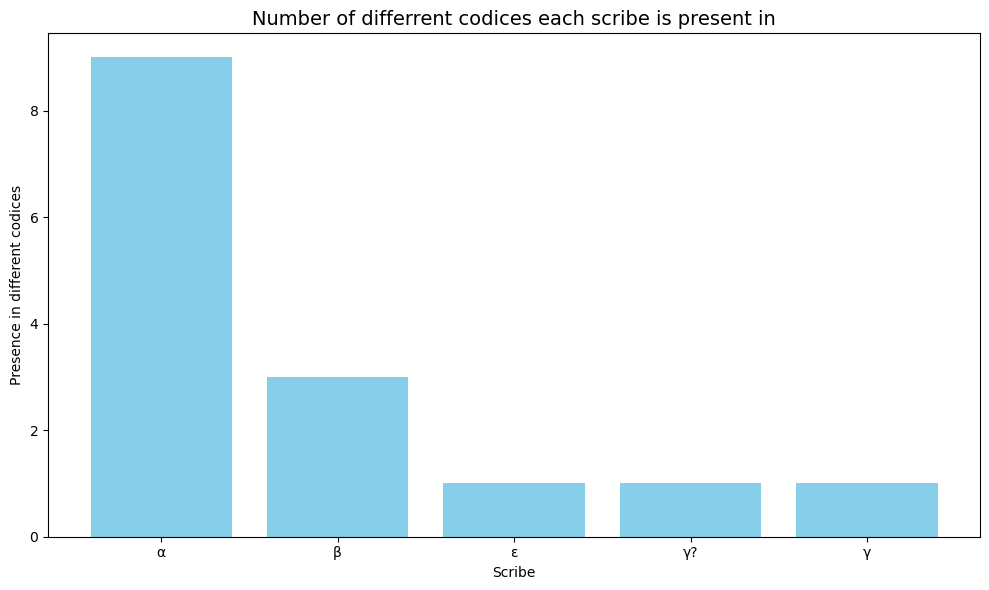

In [3]:
# [TABLE]

# Creating a bar plot that shows the number of different codices each scribe is present in

# Group by scribe and count unique codices
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε' ]
scribe_counts = transcriptions.groupby('scribe')['codex_sig'].nunique()
scribe_counts = scribe_counts.sort_values(ascending=False)
filtered_scribe_counts = scribe_counts[scribe_counts.index.isin(desired_scribes)]

# Create bar plot
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_scribe_counts.index, filtered_scribe_counts.values, color='skyblue')

# Add labels
plt.xlabel('Scribe')
plt.ylabel('Presence in different codices')
plt.title('Number of differrent codices each scribe is present in', fontsize=14)

# Increase readability

plt.tight_layout()
plt.show()


In [4]:
# Wouter?

grouped_df = transcriptions.groupby('codex_sig')

scribe_per_codex_sig = {}
for codex_sig, group in grouped_df:
    scribes = group['scribe'].astype(str).unique()
    scribe_per_codex_sig[codex_sig] = scribes
for codex_sig, scribes in scribe_per_codex_sig.items():
    print(f"{codex_sig}: {', '.join(scribes)}")


Brussel, KBR, 1805-1808: a, α, D, β, none
Brussel, KBR, 2485: β, c, nan
Brussel, KBR, 2849-51: α, none
Brussel, KBR, 2877-78: A
Brussel, KBR, 2879-80: scribe1, scribe1-scribe2, scribe2, scribe2-scribe3, scribe3
Brussel, KBR, 2905-09: unknown, α, π, none, nan
Brussel, KBR, 2979: none, B, A, α
Brussel, KBR, 3091: η, ε
Brussel, KBR, 3093-95: β, α, unknown
Gent, UB, 1374: α
Gent, UB, 941: none, scribe1, scribe1-scribe2, scribe2
Parijs, Bibliothèque Mazarine, 920: unknown, A, G, γ?, K, L, M, M-N, N, p-w
Parijs, Bibliothèque de l'Arsenal, 8224: unknown, ζ-π, ζ, C
Sint-Petersburg, BAN, O 256: none, A, A-B, B, B-G, G, nan
Wenen, ÖNB, 12.857: none, A, α, e, nan
Wenen, ÖNB, 12.905: none, d, A, B
Wenen, ÖNB, 13.708: none, α
Wenen, ÖNB, 65: γ, a, α


We merge together all texts from the same production units.

In [5]:
units = []
plain_char = re.compile("[A-Za-z]+")

for prod_unit_id, prod_unit in transcriptions.groupby('id'):
    prod_unit = prod_unit.sort_values('transkribuspage')
    prod_unit = prod_unit[~prod_unit['text'].isna()]
    if not len(prod_unit):
        continue
    text = ' '.join(t for t in prod_unit['text']) # join all texts together (for the same prod_unit)
    text = ' '.join(text.strip().split())
    
    date = prod_unit.sample(1)['date'].values[0]
    scribe = prod_unit.sample(1)['scribe'].values[0]
    sig = prod_unit.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(prod_unit['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = prod_unit.sample(1)['translator'].values[0]
    units.append((prod_unit_id, date, text, scribe, sig, prod_unit_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H

,pu,date,text,scribe,signature,id,translator,content
0,"Brussel, KBR, 1805-1808-I-a",1400,Een voorredene op sinte gregoriꝰ dyalogus DE z...,"Brussel, KBR, 1805-1808-a","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-I-a",bibletranslator,proloog
1,"Brussel, KBR, 1805-1808-I-α",1395,Hier beghint een voʼredene op .Sʼ. gᵉgorius dy...,α,"Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-I-α",bibletranslator,dialogenGreg1_3
2,"Brussel, KBR, 1805-1808-II-D",1395,Hiʼ begēt de pierde boec vā gᵉgerna ¶ Dyalogus...,"Brussel, KBR, 1805-1808-D","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-II-D",bibletranslator,dialogenGreg4
3,"Brussel, KBR, 1805-1808-II-α",1395,De dʼde boec gaꝫ hiʼ vte Hiʼ volgen dē capitee...,α,"Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-II-α",none,inhoudsopgave
4,"Brussel, KBR, 1805-1808-III-none",1395,DJt boec hoert den bruedʼs vādē goede cloestin...,"Brussel, KBR, 1805-1808-none","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-III-none",none,none
...,...,...,...,...,...,...,...,...
105,"Wenen, ÖNB, 65-I-a",1375-1400,liber iste ꝑtinet ad cenob sā pauli zonia Dor...,"Wenen, ÖNB, 65-a","Wenen, ÖNB, 65","Wenen, ÖNB, 65-I-a",NaN,note
106,"Wenen, ÖNB, 65-I-γ",1375-1400,‡ d blie die pase on heeren ihoes so voerga en...,γ,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-I-γ",NaN,TOC
107,"Wenen, ÖNB, 65-II-α",1375-1400,huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...,α,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-II-α",NaN,horlogium
108,"Wenen, ÖNB, 65-III-γ",1375-1400,vᵃ De wijsheit . Dat en mach niet sijn . Noch ...,γ,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-III-γ",NaN,horlogium


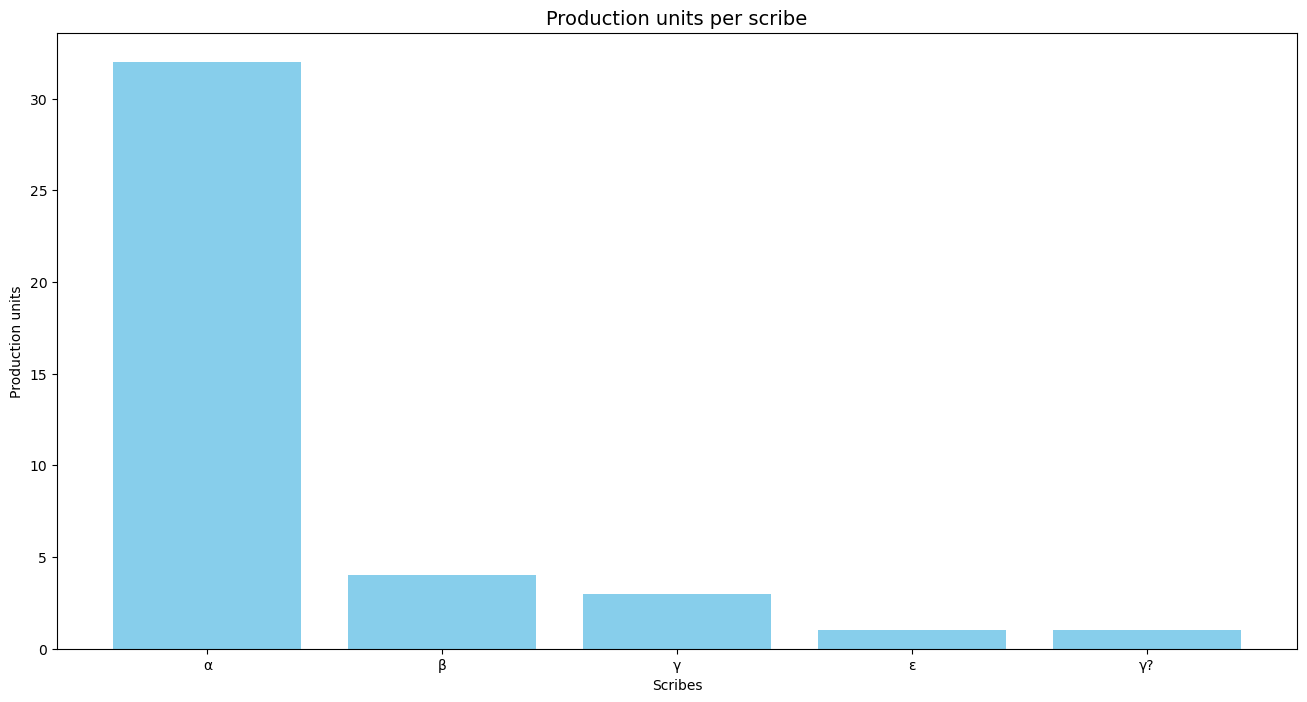

In [6]:
# [TABLE]

# Creating a bar plot with production units per scribe

# Define the desired scribes
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']

# Filter the DataFrame for the desired scribes
filtered_data = H[H['scribe'].isin(desired_scribes)]

# Create a bar plot with production units per scribe
pu_per_scribe = dict(filtered_data['scribe'].value_counts())

# Create plot
plt.figure(figsize=(16, 8))
plt.bar(pu_per_scribe.keys(), pu_per_scribe.values(), color='skyblue')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Production units')
plt.title('Production units per scribe', fontsize=14)

# Increase readability
plt.xticks(fontsize=10)

plt.show()

In [10]:
# If a date is approximated (f.e. 1325-1350), we have to convert it 
# to one single year in order to work with it. Accordingly, we calculate
# the mean and store it in the 'num_date'-column

num_dates = []

for d in H['date']:
    if d in ('unknown', 'no', 'none'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
71,"Sint-Petersburg, BAN, O 256-II-G",1325-1350,es and net aeroeg ē en wna M8 Sadoch ghebaer a...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,1337.5,127527
75,"Sint-Petersburg, BAN, O 256-IV-A",1325-1350,he niet sacharia wāt dins bedīghe es ghe horꝫ ...,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,1337.5,30113
76,"Sint-Petersburg, BAN, O 256-V-G",1325-1350,Jo huse mis vadʼ sijn vele wonīghē Eest dat i...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-V-G",NaN,evangJoh,1337.5,2090
70,"Sint-Petersburg, BAN, O 256-I-II-B-G",1325-1350,E nedʼ gaende . Op alre heilighē . dʼ mᵗ .v. ...,B-G,"Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-II-B-G",NaN,perikopen-evangMath - perikoken-evangMath,1337.5,3075
56,"Parijs, Bibliothèque Mazarine, 920-V-K",1325-1350,Uviltu comē toten euliken leuēne soe hout die ...,"Parijs, Bibliothèque Mazarine, 920-K","Parijs, Bibliothèque Mazarine, 920","Parijs, Bibliothèque Mazarine, 920-V-K",NaN,collatioBonav - collatioBonav-zevengaven - zev...,1337.5,22258
...,...,...,...,...,...,...,...,...,...,...
66,"Parijs, Bibliothèque de l'Arsenal, 8224-none-u...",none,,"Parijs, Bibliothèque de l'Arsenal, 8224-unknown","Parijs, Bibliothèque de l'Arsenal, 8224","Parijs, Bibliothèque de l'Arsenal, 8224-none-u...",NaN,vulgaat,NaN,0
77,"Sint-Petersburg, BAN, O 256-none-none",none,,"Sint-Petersburg, BAN, O 256-none","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-none-none",NaN,none,NaN,0
81,"Wenen, ÖNB, 12.857-none-none",no,. Die .iiij. euangelisten .,"Wenen, ÖNB, 12.857-none","Wenen, ÖNB, 12.857","Wenen, ÖNB, 12.857-none-none",NaN,none,NaN,27
86,"Wenen, ÖNB, 12.905-none-none",none,sche wijf op sittet . Dꝫ sijn die liede e die...,"Wenen, ÖNB, 12.905-none","Wenen, ÖNB, 12.905","Wenen, ÖNB, 12.905-none-none",NaN,none,NaN,846


In [11]:
# Filters out any short text with a length less than 1000 characters

print(len(H))
H = H[H['length'] > 1000]
print(len(H))

110
76


## Cleaning the data

We separate the characters into three categories: (regular) letters, glyphs, and punctuation.

In [12]:
# To create the dictionaries with letters, glyphs, and punctuation,
# we only use the ground truth transcriptions (not the HTR transcriptions).
# That way, we are sure no artifacts of the model are included.

allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
print(allowed_chars)

Counter({' ': 259428, 'e': 208715, 'd': 69361, 't': 68258, 'i': 66844, 'n': 62178, 's': 61677, 'a': 49368, 'h': 45660, 'o': 44860, 'l': 42615, '\n': 42402, 'ē': 41857, 'r': 34693, 'g': 31082, 'c': 30966, 'm': 26172, 'ʼ': 23986, 'u': 20062, 'w': 19107, '.': 16628, 'v': 16520, 'b': 13885, '\ue5dc': 12539, ':': 9737, 'ī': 8796, 'k': 8726, 'ā': 8160, 'p': 7881, 'ꝫ': 7401, 'D': 6957, '-': 6414, 'f': 5574, 'E': 5500, 'ō': 5290, 'j': 4608, 'ᵗ': 3327, '\ue554': 2257, 'W': 2113, 'y': 2032, 'S': 2022, 'M': 1790, 'H': 1711, 'x': 1582, 'A': 1580, 'J': 1578, 'ᵃ': 1518, 'ᵒ': 1425, 'z': 1263, 'ᵉ': 1224, 'N': 1097, 'V': 1024, 'q': 988, 'ꝟ': 975, 'O': 871, 'ꝰ': 847, 'G': 822, 'ⁱ': 766, '¶': 588, 'T': 491, 'B': 438, 'ⁿ': 393, '̄': 386, 'ꝑ': 314, '\ue5b8': 308, 'ᵛ': 294, 'ū': 290, '\ue665': 263, 'I': 239, 'ᷣ': 213, '⸫': 212, 'ꝓ': 209, 'ꝯ': 178, 'L': 178, 'C': 172, '‡': 149, '|': 137, 'R': 122, 'Z': 121, '\uf160': 118, 'Ō': 117, '1': 117, 'P': 100, '3': 93, '2': 90, '‸': 81, '4': 71, '6': 52, '\uf161': 50

In [13]:
plain_char = re.compile("[A-Za-z]+")

# the following characters are also glyphs, but we need to add them
# manually, otherwise they're recognized as punctuation
unicode_glyphs = [u'\ue5dc', u'\ue554', u'\ue5b8', u'\ue665', u'ᷣ', u'̄', u'᷑',
                  u'\ue74d', u'\ue8e5', u'\ueed7', u'\ue681', u'\ue1dc', u'\ue154']

letters, glyphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha() or g in unicode_glyphs:  # Include the custom-defined Unicode glyphs!!
        glyphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
glyphs = Counter(dict(glyphs))
punctuation = Counter(dict(punctuation))

print(letters.most_common(5))
print(glyphs.most_common(5))
print(punctuation.most_common(5))
print(glyphs)

[('e', 208715), ('d', 69361), ('t', 68258), ('i', 66844), ('n', 62178)]
[('ē', 41857), ('ʼ', 23986), ('\ue5dc', 12539), ('ī', 8796), ('ā', 8160)]
[('.', 16628), (':', 9737), ('-', 6414), ('¶', 588), ('⸫', 212)]
Counter({'ē': 41857, 'ʼ': 23986, '\ue5dc': 12539, 'ī': 8796, 'ā': 8160, 'ꝫ': 7401, 'ō': 5290, 'ᵗ': 3327, '\ue554': 2257, 'ᵃ': 1518, 'ᵒ': 1425, 'ᵉ': 1224, 'ꝟ': 975, 'ꝰ': 847, 'ⁱ': 766, 'ⁿ': 393, '̄': 386, 'ꝑ': 314, '\ue5b8': 308, 'ᵛ': 294, 'ū': 290, '\ue665': 263, 'ᷣ': 213, 'ꝓ': 209, 'ꝯ': 178, 'Ō': 117, '᷑': 49, 'ˢ': 46, 'ᶜ': 43, 'ħ': 43, 'ᵐ': 26, 'ẜ': 20, 'ꝝ': 16, 'ð': 13, 'ᵈ': 12, 'ȳ': 11, 'ʳ': 10, 'Ꝑ': 10, 'ᵘ': 9, '\ue154': 8, 'Ꝟ': 7, 'ᶦ': 6, '\ue681': 6, 'Ā': 5, 'Ē': 4, 'ꞏ': 4, 'ꝙ': 2, 'ƶ': 2, '\ueed7': 1, 'ø': 1, '\ue1dc': 1, 'ȣ': 1, 'ω': 1, 'Ꝓ': 1, '\ue74d': 1, '\ue8e5': 1, 'Ꝝ': 1, 'Ꝯ': 1})


In [14]:
# Now, we clean the text of the HTR transcriptions based on the 
# ground truth characters that we found. That way, possible 'weird' 
# characters that the model recognised, are excluded.
# In other words, we only keep characters that are attested in the 
# ground truth transcriptions.

def clean(text):
    text = ' '.join(text.split()) # delete unnecessary whitespace
    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/1128477343.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(clean)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
71,"Sint-Petersburg, BAN, O 256-II-G",1325-1350,es and net aeroeg ē en wna M8 Sadoch ghebaer a...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,1337.5,127527
75,"Sint-Petersburg, BAN, O 256-IV-A",1325-1350,he niet sacharia wāt dins bedīghe es ghe horꝫ ...,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,1337.5,30113
76,"Sint-Petersburg, BAN, O 256-V-G",1325-1350,Jo huse mis vadʼ sijn vele wonīghē Eest dat i...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-V-G",NaN,evangJoh,1337.5,2090
70,"Sint-Petersburg, BAN, O 256-I-II-B-G",1325-1350,E nedʼ gaende . Op alre heilighē . dʼ mᵗ .v. ...,B-G,"Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-II-B-G",NaN,perikopen-evangMath - perikoken-evangMath,1337.5,3075
56,"Parijs, Bibliothèque Mazarine, 920-V-K",1325-1350,Uviltu comē toten euliken leuēne soe hout die ...,"Parijs, Bibliothèque Mazarine, 920-K","Parijs, Bibliothèque Mazarine, 920","Parijs, Bibliothèque Mazarine, 920-V-K",NaN,collatioBonav - collatioBonav-zevengaven - zev...,1337.5,22258
...,...,...,...,...,...,...,...,...,...,...
92,"Wenen, ÖNB, 13.708-III-α",1402,Dandʼ ꝑtie vanden spiegele hystoriale Dierste ...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-III-α",NaN,sph2-1,1402.0,93268
93,"Wenen, ÖNB, 13.708-IV-α",1402,Dander ptie Dē vorredene vā dē andʼen boeke WJ...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-IV-α",NaN,sph2-2,1402.0,106455
90,"Wenen, ÖNB, 13.708-II-α",1402,a Doemē screef .m.ccc. e .xcvi. op de derde n...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-II-α",NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...,1402.0,147236
88,"Wenen, ÖNB, 13.708-I-α",1402,pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,1402.0,28844


In [15]:
# Now we remove punctuation

hyphenation_break = re.compile(r'\-\s+')
numeric = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(hyphenation_break, '', text) # detecting hyphenation breaks, deleting them
    text = re.sub(numeric, '', text) # detecting numeric characters, deleting them
    return ''.join([c for c in text if c not in punctuation]) # deleting punctuation

H['text'] = H['text'].apply(rm_punct)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/993403248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(rm_punct)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
71,"Sint-Petersburg, BAN, O 256-II-G",1325-1350,es and net aeroeg ē en wna M Sadoch ghebaer ac...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,1337.5,127527
75,"Sint-Petersburg, BAN, O 256-IV-A",1325-1350,he niet sacharia wāt dins bedīghe es ghe horꝫ ...,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,1337.5,30113
76,"Sint-Petersburg, BAN, O 256-V-G",1325-1350,Jo huse mis vadʼ sijn vele wonīghē Eest dat i...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-V-G",NaN,evangJoh,1337.5,2090
70,"Sint-Petersburg, BAN, O 256-I-II-B-G",1325-1350,E nedʼ gaende Op alre heilighē dʼ mᵗ v E s...,B-G,"Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-II-B-G",NaN,perikopen-evangMath - perikoken-evangMath,1337.5,3075
56,"Parijs, Bibliothèque Mazarine, 920-V-K",1325-1350,Uviltu comē toten euliken leuēne soe hout die ...,"Parijs, Bibliothèque Mazarine, 920-K","Parijs, Bibliothèque Mazarine, 920","Parijs, Bibliothèque Mazarine, 920-V-K",NaN,collatioBonav - collatioBonav-zevengaven - zev...,1337.5,22258
...,...,...,...,...,...,...,...,...,...,...
92,"Wenen, ÖNB, 13.708-III-α",1402,Dandʼ ꝑtie vanden spiegele hystoriale Dierste ...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-III-α",NaN,sph2-1,1402.0,93268
93,"Wenen, ÖNB, 13.708-IV-α",1402,Dander ptie Dē vorredene vā dē andʼen boeke WJ...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-IV-α",NaN,sph2-2,1402.0,106455
90,"Wenen, ÖNB, 13.708-II-α",1402,a Doemē screef mccc e xcvi op de derde none v...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-II-α",NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...,1402.0,147236
88,"Wenen, ÖNB, 13.708-I-α",1402,pᵃ ꝓbaᵒ Jn dese na volgende qᵉstie wʼt gepᵛeft...,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,1402.0,28844


In [16]:
# Waarom precies? Is dit een goed idee
# Kunnen misischien ook plots maken met enkel punct?
# Eens draaien met ook interpunctie erbij
# Tridot: getranscribeerd als dubbele punt met streepje (Mike) = 2 unicode tekens
# MUFI: er is een unicode teken dat wel een geheel is (Wouter)
# misschien niet altijd even consequent getranscribeerd --> daarom eruit
# kunnen het eens proberen zonder die varianten
# nog een reden: stel in 1 manuscript heel veel aantekeningen in de marge: dan duidt kopiist dat aan met een punt. eerst margi aantekening: 1 puntje in de tekst en 1 in de margi. Volgende verbetering: 2 in de tekst, 2 aan de zijkant. Tridot daar ook voor gebruikt


/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/1619485041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['len'] = text_len['text'].apply(len)


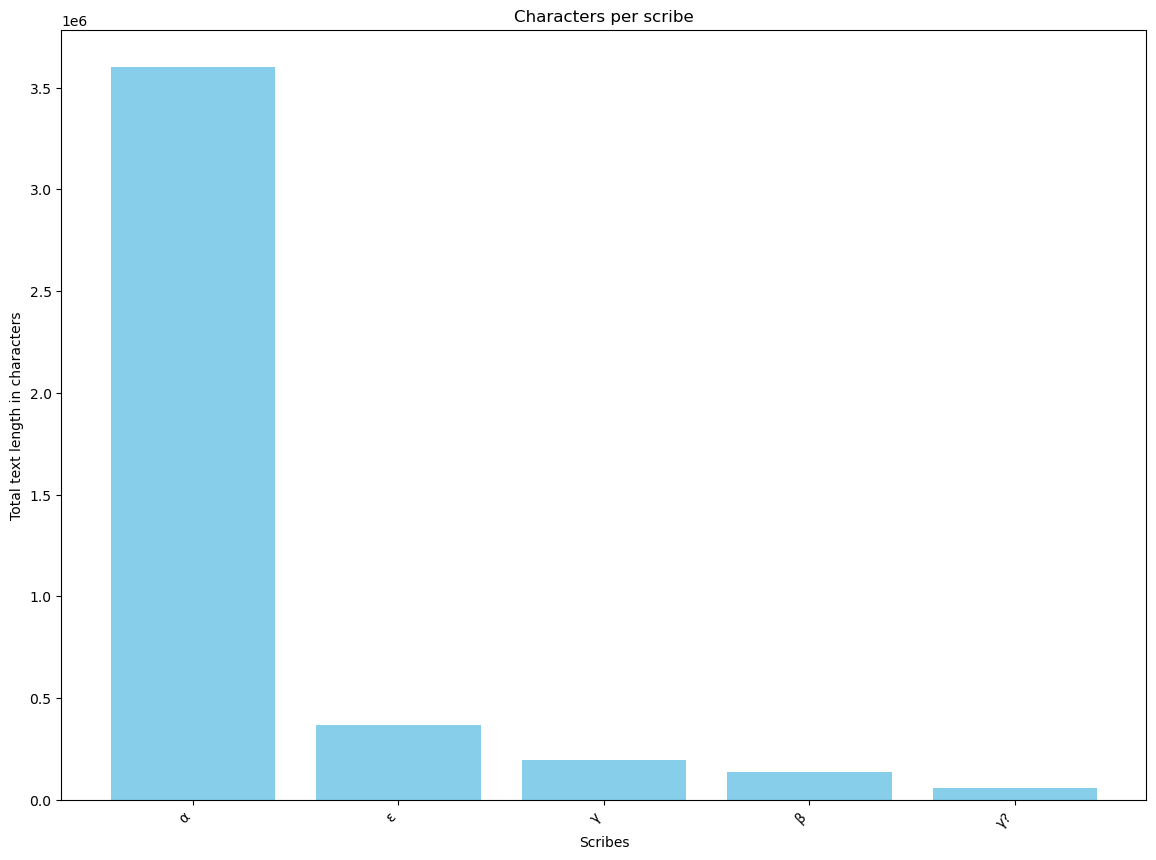

In [23]:
# [TABLE]

# Creating a bar plot with the total amount of characters produced by each scribe

# Calculating the amount of characters by adding up the length of all texts written by each scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]
text_len['len'] = text_len['text'].apply(len)
scribe_text_len = dict(text_len.groupby('scribe')['len'].sum().sort_values(ascending=False))

# Creating the bar plot
plt.figure(figsize=(14, 10))
plt.bar(scribe_text_len.keys(), scribe_text_len.values(), color='skyblue')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Total text length in characters')
plt.title('Characters per scribe')

# Increasing readability
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.show()

In [24]:
scribe_text_len

{'α': 3603857, 'ε': 365975, 'γ': 194809, 'β': 136045, 'γ?': 58871}

In [25]:
# [TABLE]

# Get amount of unique characters per scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]

# Combine all texts
combined_text = text_len.groupby('scribe')['text'].sum()

# Unique characters
scribe_unique_chars = combined_text.apply(lambda x: len(set(x)))
scribe_unique_chars

scribe
α     107
β      79
γ      73
γ?     69
ε      75
Name: text, dtype: int64

In [26]:
# [TABLE]

# Calculating the TTR
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]

# Calculate amount of words
text_len['tokens'] = text_len['text'].apply(lambda x: len(x.split()))  # Assuming words are separated by spaces

# Calculate amount of unique words
text_len['unique_tokens'] = text_len['text'].apply(lambda x: len(set(x.split())))

# Divide
scribe_ttr = (text_len.groupby('scribe')['unique_tokens'].sum() / text_len.groupby('scribe')['tokens'].sum()).sort_values(ascending=False)
scribe_ttr

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/1279578335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['tokens'] = text_len['text'].apply(lambda x: len(x.split()))  # Assuming words are separated by spaces
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/1279578335.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['unique_tokens'] = text_len['text'].apply(lambda x: len(set(x.split())))


scribe
β     0.292318
γ?    0.231999
γ     0.221245
α     0.216465
ε     0.127765
dtype: float64

## Abbreviation densities

In [27]:
# We split up the texts into segments of 5000 characters

segment_size = 5000
segments = []

for _, row in H.iterrows():
    starting_index, ending_index = 0, segment_size
    text = row['text']
    while ending_index < len(text):
        segments.append((text[starting_index:ending_index], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        starting_index += segment_size
        ending_index += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

,text,date,scribe,signature,id,translator,content
1036,Die ī dese eere es dꝰ gedaen En es al selc nᵗ...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-VIII-α",NaN,sph2-6
1105,nien dan hi besittē soude Here die wille si ...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-V-α",NaN,sph2-3
1175,ad gode mꝫ nerenstechedē Dat hine tot hē halē ...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-IV-α",NaN,sph2-2
685,n sal dine slinke hāt niet wetē wat di ne rech...,1387.5,α,"Wenen, ÖNB, 12.857","Wenen, ÖNB, 12.857-IV-α",NaN,evang
242,s dese dīghe leerē Wi selē anesiē desē gulden...,1362.5,ε,"Brussel, KBR, 3091","Brussel, KBR, 3091-I-ε",NaN,tabernRuusbr


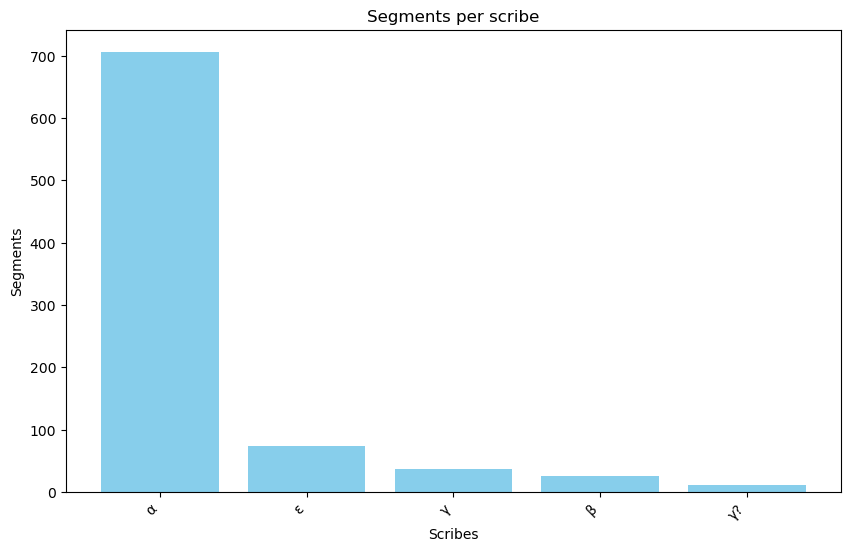

In [28]:
# [TABLE]

# Bar plot with segments per scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
segments_per_scribe = segments[segments['scribe'].isin(desired_scribes)]
segments_per_scribe = dict(segments_per_scribe['scribe'].value_counts())

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(segments_per_scribe.keys(), segments_per_scribe.values(), color='skyblue')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Segments')
plt.title('Segments per scribe')

# Increasing readability
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.show()

We calculate two types of abbreviation density:

- character abbreviation density: glyphs (which indicate abbreviation) divided by *all* 'normal' letters;
- word abbreviation density: abbreviated words divided by full-length words.

In [29]:
def abbr_density_character(text):
    
    cnts = Counter(unicodedata.normalize('NFC', text))
    alph = np.sum([cnts[c] for c in set(letters)]) # count all letters
    glph = np.sum([cnts[c] for c in set(glyphs)]) # count all glyphs
    return glph / alph # glyphs divided by letters

densities_character = [abbr_density_character(t) for t in segments['text']]
segments['abbr_char'] = densities_character # abbreviation density per segment

In [30]:
def abbr_density_word(text, counter):
    
    # A regular expression to find words, including Latin extensions such as macrons (ā, ē, ī, ō, ū)
    # and other specific characters (ʓ, ʒ, ̄, Ẕ, Ṕ, ṕ, ū̄, ē̄, ā̄, ī̄, ō̄, ȳ, ġ, Ā, Ǡ, ǡ, ǣ, Ǣ, ̄̄, ̄̆, ̄̍)
    # If we did not make this explicit, some characters would be interpreted as punctuation
    words = re.findall(r'\b(?:[\w\u0101\u0100\u0113\u0112\u012b\u012A\u014D\u014C\u016B\u016A\u0233\u0232\u0304\uE554\uE154\uE5B8\uE5DC\uE665\uE681]+)(?=\b|$)', text.lower())
    
    num_abbr_words = 0
    num_total_words = 0
    abbr_words = []

    for word in words:
        if '\u016A' in word:
            print(f"Word containing '\\u016A': {word}")

    for word in words:
        cnts = Counter(unicodedata.normalize('NFD', word))
        alph = np.sum([cnts[c] for c in set(letters)])
        glph = np.sum([counter[c] for c in cnts if c in counter])

        if glph > 0:
            num_abbr_words += 1
            abbr_words.append(word)

        num_total_words += 1

    density = num_abbr_words / num_total_words
    return density, abbr_words

densities_word = []
abbreviated_words = []

for t in segments['text']:
    density, abbr_words = abbr_density_word(t, glyphs)
    densities_word.append(density)
    abbreviated_words.extend(abbr_words)

segments['abbr_word'] = densities_word

In [31]:
segments

,text,date,scribe,signature,id,translator,content,abbr_char,abbr_word
0,es and net aeroeg ē en wna M Sadoch ghebaer ac...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.118820,0.337461
1,oemēdʼ erscap Daerōme doet wʼdeghe vᵒcht dʼ p...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.124007,0.345114
2,r op enen caudelare opt dat se lichte hen alle...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.110703,0.291457
3,E hē die mꝫ di wilt dinghē in dē vōnesse e ...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.113425,0.310757
4,e gloriē alse ene vā chs thʼs s porte wāt d...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.126480,0.332687
...,...,...,...,...,...,...,...,...,...
1213,gende te hare di moꝫ si vornemēde sorge de go...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.193282,0.485915
1214,aʼ teerlīge e spele selē wi vindē bi vele lie...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.183846,0.474438
1215,atine gekeʼt op datse alle mēschē gʼekē e ba...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.202186,0.530955
1216,maect si die vā hoegʼ e van gᵒtʼ matʼiē tᵃc...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.190893,0.510438


Calculating the character abbreviation density for all of the scribes:

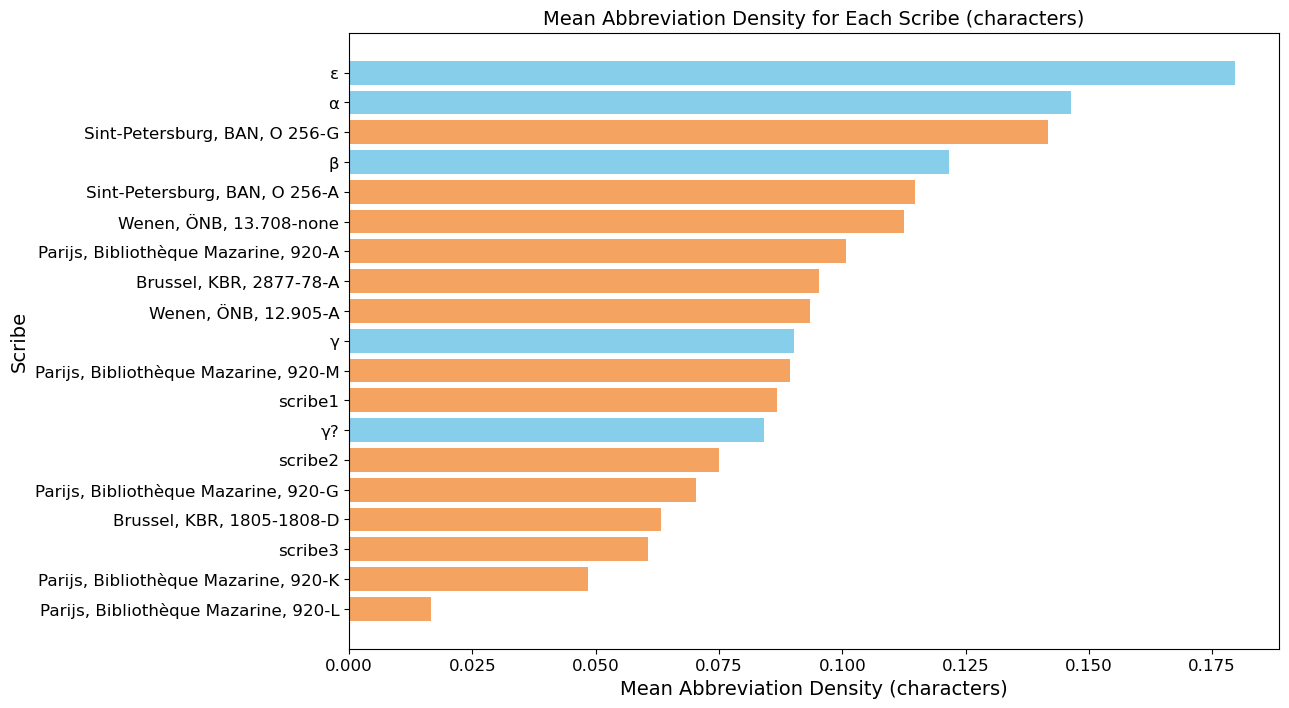

In [32]:
# Calculate mean abbreviation rate for each scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε' ]
mean_abbr_rate = segments.groupby('scribe')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
mean_abbr_rate = mean_abbr_rate.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(mean_abbr_rate['scribe'], mean_abbr_rate['abbr_char'], color=['skyblue' if scribe in desired_scribes else 'sandybrown' for scribe in mean_abbr_rate['scribe']])

# Set the title and labels
plt.title('Mean Abbreviation Density for Each Scribe (characters)', fontsize=14)
plt.xlabel('Mean Abbreviation Density (characters)', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Calculating the word abbreviation density for all of the scribes:

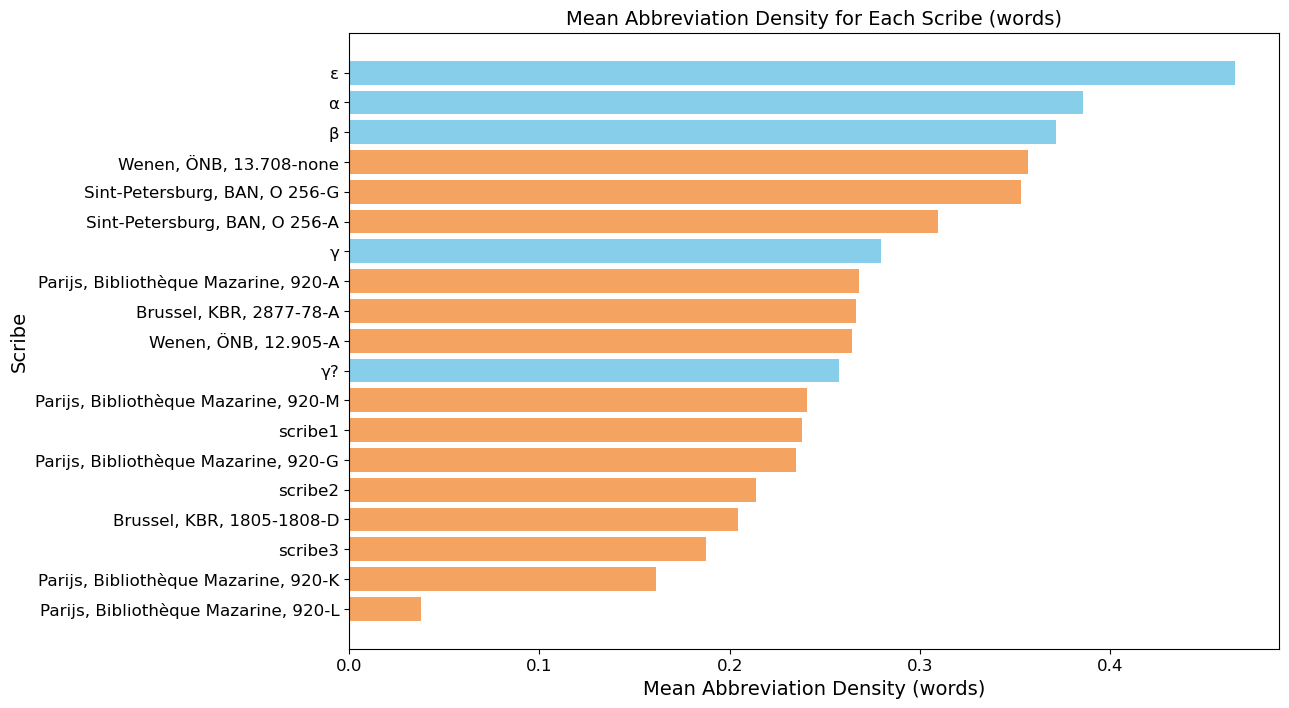

In [33]:
# Calculate mean abbreviation rate for each scribe
mean_abbr_rate = segments.groupby('scribe')['abbr_word'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
mean_abbr_rate = mean_abbr_rate.sort_values(by='abbr_word', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(mean_abbr_rate['scribe'], mean_abbr_rate['abbr_word'], color=['skyblue' if scribe in desired_scribes else 'sandybrown' for scribe in mean_abbr_rate['scribe']])

# Set the title and labels
plt.title('Mean Abbreviation Density for Each Scribe (words)', fontsize=14)
plt.xlabel('Mean Abbreviation Density (words)', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Observations:
- The known Herne scribes seem to use abbreviations regularly.

Accordingly, we will zoom in on them individually
    

#### Alpha individually:

In [34]:
# Filter the segments DataFrame for scribe alpha
scribe_alpha_segments = segments[segments['scribe'] == 'α']

# Calculate the average abbreviation density
average_density_scribe_alpha_word = scribe_alpha_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_alpha_word}')

average_density_scribe_alpha = scribe_alpha_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_alpha}')

word abbreviation density: 0.38544098414487404
character abbreviation density: 0.14639015261192115


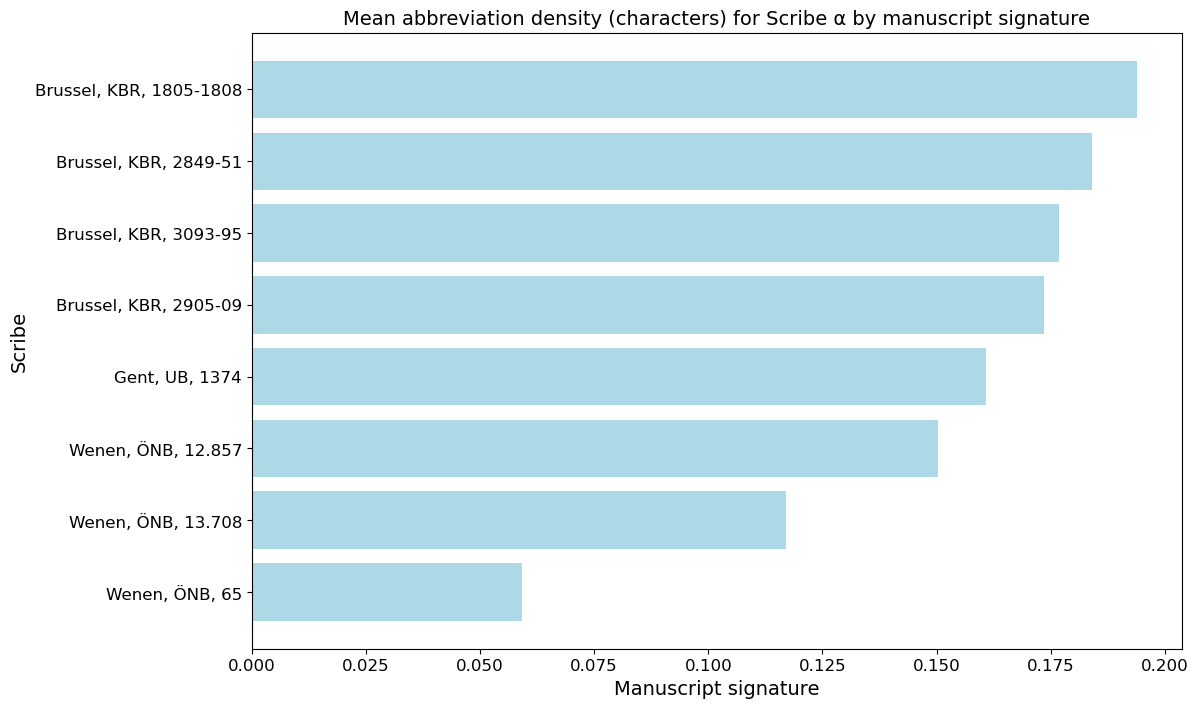

In [35]:
# filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'α'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data = filtered_data.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(filtered_data['signature'], filtered_data['abbr_char'], color='lightblue')

# Set the title and labels
plt.title('Mean abbreviation density (characters) for Scribe α by manuscript signature', fontsize=14)
plt.xlabel('Manuscript signature', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Observations:
- Vienna, ÖNB, 65; Vienna, ÖNB, 13.708; Vienna, ÖNB, 12.857; seem to differ in terms of abbreviation density.

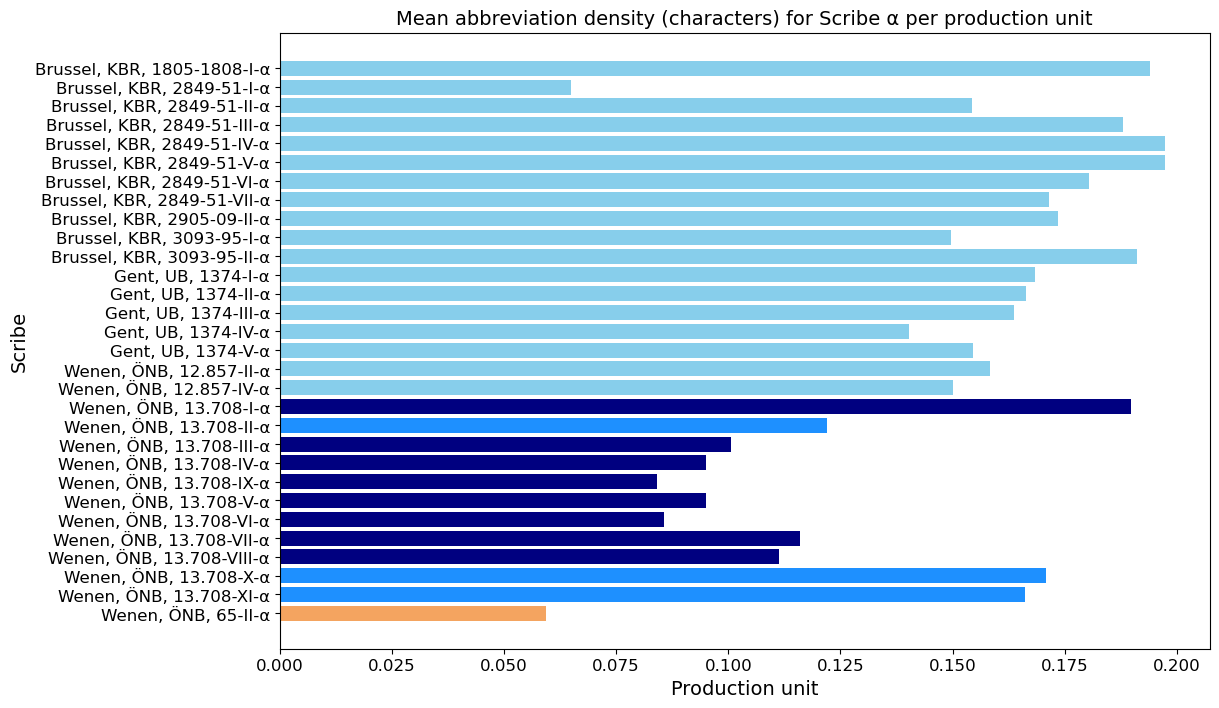

In [36]:
# Filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'α'].groupby('id')['abbr_char'].mean().reset_index()

# Sample y-labels and corresponding colors
y_labels = filtered_data['id'].unique()
color_map = {'Wenen, ÖNB, 13.708-II-α': 'dodgerblue',
             'Wenen, ÖNB, 13.708-X-α': 'dodgerblue',
             'Wenen, ÖNB, 13.708-XI-α': 'dodgerblue',
             'Wenen, ÖNB, 13.708-I-α': 'navy',
             'Wenen, ÖNB, 13.708-III-α': 'navy',
             'Wenen, ÖNB, 13.708-IV-α': 'navy',
             'Wenen, ÖNB, 13.708-V-α': 'navy',
             'Wenen, ÖNB, 13.708-VI-α': 'navy',
             'Wenen, ÖNB, 13.708-VII-α': 'navy',
             'Wenen, ÖNB, 13.708-VIII-α': 'navy',
             'Wenen, ÖNB, 13.708-I-α': 'navy',
             'Wenen, ÖNB, 13.708-IX-α': 'navy',
             'Wenen, ÖNB, 65-II-α': 'sandybrown'
            }


# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart with manually specified colors
bars = plt.barh(filtered_data['id'], filtered_data['abbr_char'], color=[color_map.get(label, 'skyblue') for label in y_labels])

# Set the title and labels
plt.title('Mean abbreviation density (characters) for Scribe α per production unit', fontsize=14)
plt.xlabel('Production unit', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Observations:
- 13.708:
    - old core: II, X, XI --> higher abbreviation density (1393-1394)
    - new core: 1402
    - "Productie-eenheid I is zelfs gedeeltelijk opgebouwd uit een (onbeschreven) deel van de oude kern (vgl. §3.2)." --> maybe not onbeschreven? Looking at the abbreviation density.
    - In de oude kern zijn 56 teksten opgenomen, terwijl in de acht toegevoegde delen slechts twee teksten zijn te vinden: een vertaling van het zevende hoofdstuk van Zerbolt van Zutphens Super modo vivendi, over de boeken die in de volkstaal gelezen mogen worden (productie-eenheid 1), en de nagenoeg volledige Tweede Partie van de Spiegel historiael vertaald door Philip Utenbroeke (productie-eenheid Ill-IX).40
    - Voetnoot!!! Biemans meent dat de eerste productie-eenheid (f. 1-5) reeds in 1394 kan zijn toegevoegd bgl. Biemans 1997, deel 1, p. 117 en 119). Dit lijkt mij niet erg waarschijnlijk gezien de conemporaine foliering (‘1’) op het laatste blad van die eenheid (f. 5 modem), die pas werd aangeracht nadat de elf delen rond 1402 werden .samengebonden.
    

Let's have a closer look at Vienna, ÖNB, 65

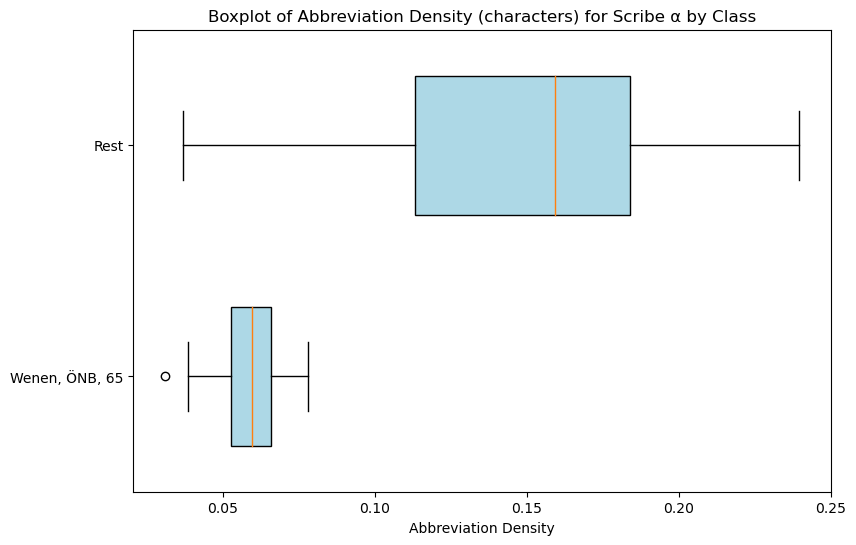

In [37]:
# Add the 'class' column to the segments DataFrame
classes = ['Wenen, ÖNB, 65' if sig == 'Wenen, ÖNB, 65' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Wenen, ÖNB, 65', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Wenen, ÖNB, 65', 'Rest'], vert=False, widths=0.6, patch_artist=True)

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α by Class', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Wenen, ÖNB, 65', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


Let's have a closer look at Vienna, ÖNB, 12.857

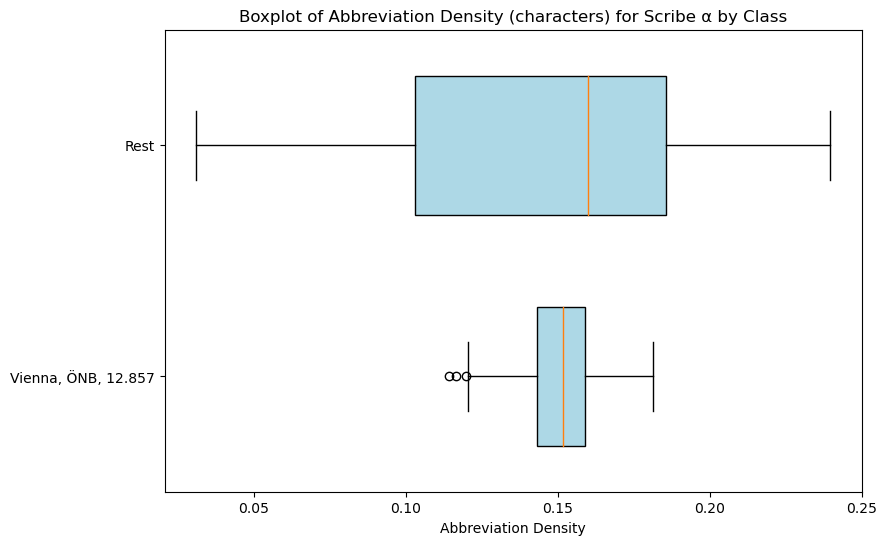

In [38]:
# Add the 'class' column to the segments DataFrame
classes = ['Wenen, ÖNB, 12.857' if sig == 'Wenen, ÖNB, 12.857' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Wenen, ÖNB, 12.857', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Wenen, ÖNB, 12.857', 'Rest'], vert=False, widths=0.6, patch_artist=True)

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α by Class', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Vienna, ÖNB, 12.857', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


Let's have a closer look at Vienna, ÖNB, 13.708

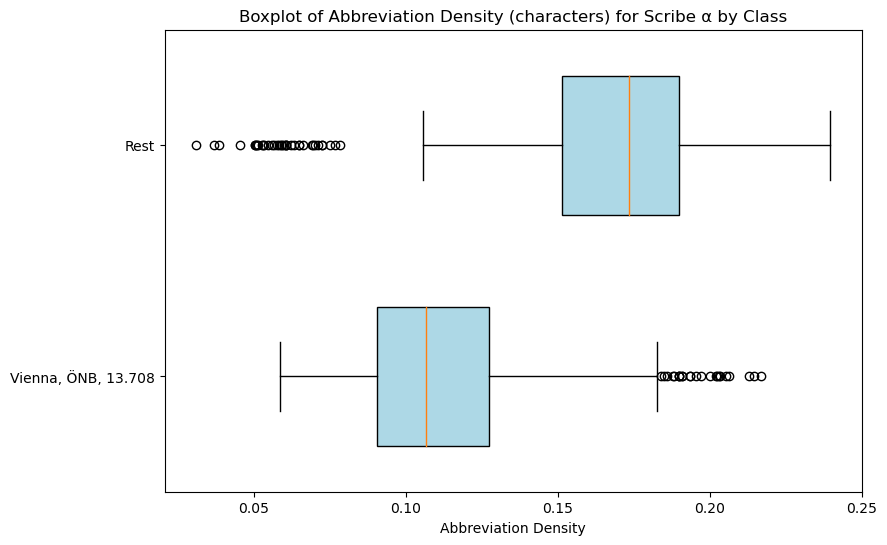

In [39]:
# Add the 'class' column to the segments DataFrame
classes = ['Wenen, ÖNB, 13.708' if sig == 'Wenen, ÖNB, 13.708' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Wenen, ÖNB, 13.708', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Wenen, ÖNB, 13.708', 'Rest'], vert=False, widths=0.6, patch_artist=True)

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α by Class', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Vienna, ÖNB, 13.708', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['lightblue', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


#### Beta individually:

In [40]:
# Filter the segments DataFrame for scribe beta
scribe_beta_segments = segments[segments['scribe'] == 'β']

# Calculate the average abbreviation densities
average_density_scribe_beta_word = scribe_beta_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_beta_word}')

average_density_scribe_beta = scribe_beta_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_beta}')

word abbreviation density: 0.3714031901134121
character abbreviation density: 0.12153705030532545


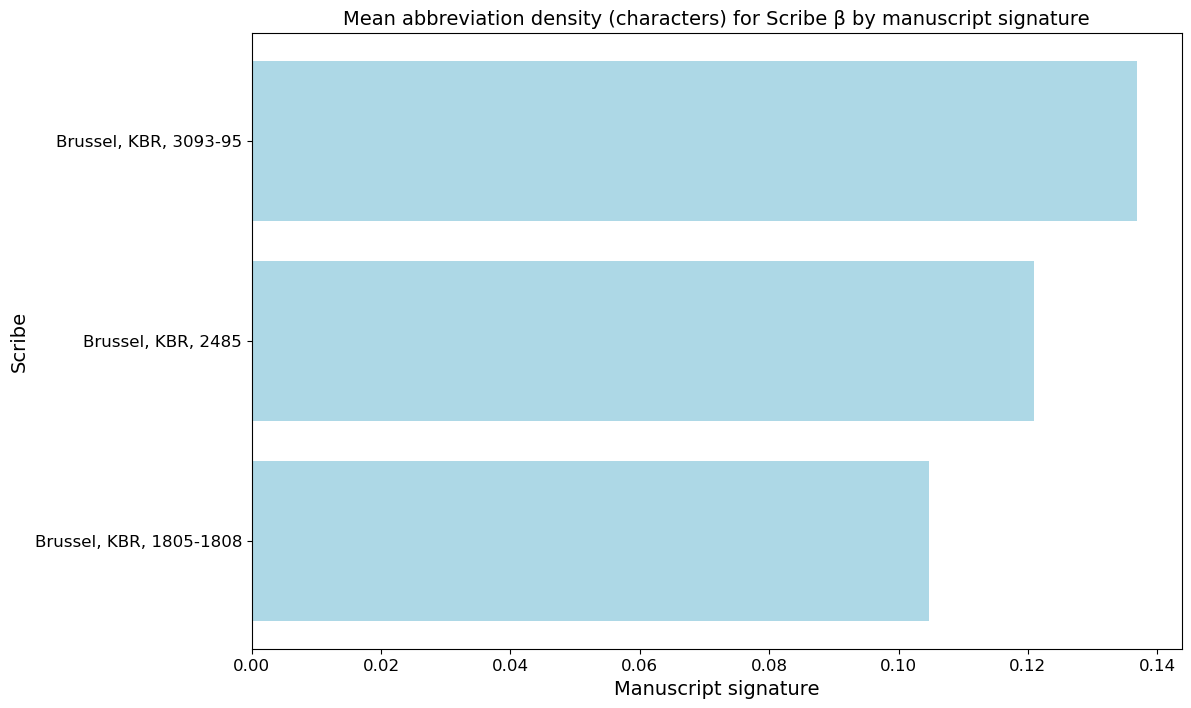

In [41]:
# filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'β'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data = filtered_data.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(filtered_data['signature'], filtered_data['abbr_char'], color='lightblue')

# Set the title and labels
plt.title('Mean abbreviation density (characters) for Scribe β by manuscript signature', fontsize=14)
plt.xlabel('Manuscript signature', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

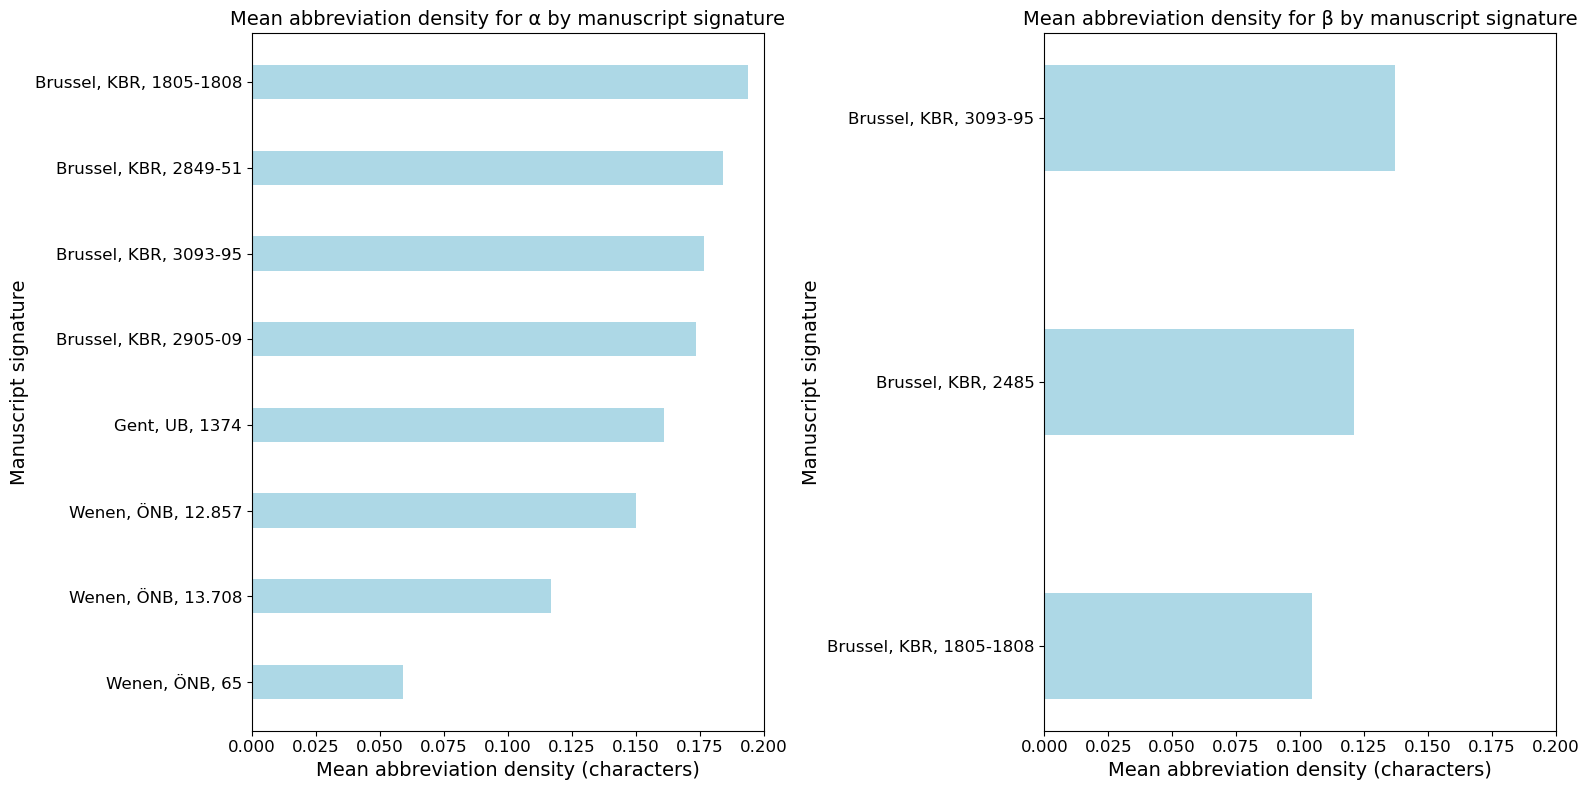

In [42]:
# Creating a plot with just α and β next to each other

# Filter data and calculate the mean abbreviation frequency for Scribe α
filtered_data_alpha = segments[segments['scribe'] == 'α'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data_alpha = filtered_data_alpha.sort_values(by='abbr_char', ascending=False)

# Filter data and calculate the mean abbreviation frequency for Scribe β
filtered_data_beta = segments[segments['scribe'] == 'β'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data_beta = filtered_data_beta.sort_values(by='abbr_char', ascending=False)

# Determine the maximum mean abbreviation density for both scribes
max_density = max(filtered_data_alpha['abbr_char'].max(), filtered_data_beta['abbr_char'].max())

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, gridspec_kw={'width_ratios': [1, 1]})

# Plot for Scribe α
bar_width = 0.4  # Adjust this value to set the bar thickness
bars_alpha = ax1.barh(filtered_data_alpha['signature'], filtered_data_alpha['abbr_char'], color='lightblue', height=bar_width, linewidth=1.2)
ax1.set_title('Mean abbreviation density for α by manuscript signature', fontsize=14)
ax1.set_xlabel('Mean abbreviation density (characters)', fontsize=14)
ax1.set_ylabel('Manuscript signature', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)
ax1.invert_yaxis()
ax1.set_xlim([0, 0.2])  # Adjusted x-axis range

# Plot for Scribe β
bars_beta = ax2.barh(filtered_data_beta['signature'], filtered_data_beta['abbr_char'], color='lightblue', height=bar_width, linewidth=1.2)
ax2.set_title('Mean abbreviation density for β by manuscript signature', fontsize=14)
ax2.set_xlabel('Mean abbreviation density (characters)', fontsize=14)
ax2.set_ylabel('Manuscript signature', fontsize=14)
ax2.tick_params(axis='both', labelsize=12)
ax2.invert_yaxis()
ax2.set_xlim([0, 0.2])  # Adjusted x-axis range

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


#### Epsilon individually (no bar plot because only one text was copied by him):

In [43]:
# Filter the segments DataFrame for scribe epsilon
scribe_epsilon_segments = segments[segments['scribe'] == 'ε']

# Calculate the average abbreviation density
average_density_scribe_epsilon_word = scribe_epsilon_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_epsilon_word}')

average_density_scribe_epsilon = scribe_epsilon_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_epsilon}')

word abbreviation density: 0.4654106304271139
character abbreviation density: 0.17956721872184375


#### Gamma individually (no bar plot because only one text was for sure copied by him):

In [44]:
# Filter the segments DataFrame for scribe gamma
scribe_gamma_segments = segments[segments['scribe'] == 'γ']

# Calculate the average abbreviation density
average_density_scribe_gamma_word = scribe_gamma_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_gamma_word}')

average_density_scribe_gamma = scribe_gamma_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_gamma}')

word abbreviation density: 0.2797930836738775
character abbreviation density: 0.09024052775699733


#### Possible gamma individually (no bar plot because there is only doubt surrounding one manuscript): 

In [45]:
# Filter the segments DataFrame for scribe gamma?
scribe_gamma_segments = segments[segments['scribe'] == 'γ?']

# Calculate the average abbreviation density
average_density_scribe_gamma_word = scribe_gamma_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_gamma_word}')

average_density_scribe_gamma = scribe_gamma_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_gamma}')

word abbreviation density: 0.25739875991069755
character abbreviation density: 0.08418126151017992


We will also have a closer look at the abbreviation density per manuscript instead of per scribe. That way, we can see whether the intended audience or content of the manuscipt influnce the amount of abbreviations.

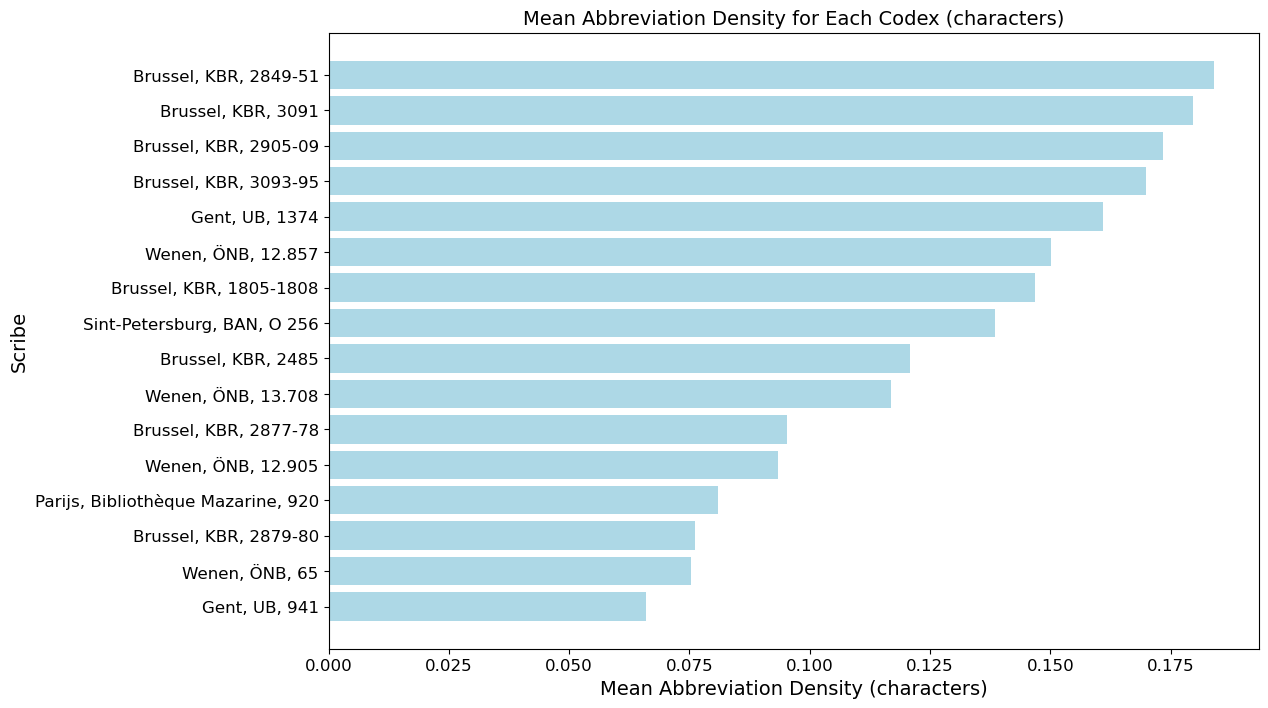

In [46]:
# Calculate mean abbreviation rate for each scribe
mean_abbr_rate = segments.groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
mean_abbr_rate = mean_abbr_rate.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(mean_abbr_rate['signature'], mean_abbr_rate['abbr_char'], color='lightblue')

# Set the title and labels
plt.title('Mean Abbreviation Density for Each Codex (characters)', fontsize=14)
plt.xlabel('Mean Abbreviation Density (characters)', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Observations: 
- Brussels, KBR, 2849-51: New Testament
- Brussels, KBR, 3091: John of Ruusbroec
- Brussels, KBR, 2905-09: _Hore Dochter_


- Ghent, UB, 941: not from Herne, also Hadewijch
- Vienna, ÖNB, 65: Seuses _Horologium_
- Brussels, KBR, 2879-80: Hadewijch

## Case Study: Derde Martijn

The _Derde Martijn_ was copied twice by α. The content in both works is identical. In Ghent, the text is written continuously, in Vienna each verse had its own line. Ghent might be a draft, for personal use, since it is 'sloppier' than Vienna. Does this influence the usage of abbreviations?

In [47]:
with open('data/derde_martijn/Ghent1374_DerdeMartijn.txt', encoding='utf-8') as f:
    G = f.read()
with open('data/derde_martijn/ONB13708_DerdeMartijn.txt', encoding='utf-8') as f:
    W = f.read()

G = clean(rm_punct(G))
W = clean(rm_punct(W))

print(G[:100])
print(W[:100])

print('Ghent:', abbr_density_character(G).round(4))
print('Vienna:', abbr_density_character(W).round(4))

En̄ hier volgt de dʼde boec IC māne mettē wiuē Die dit gedichte lesē en̄ scᶦuē Op dē hoechstē ban Dꝫ
Hier willic settē dē dʼdē boec vā wapen mʼtē die iacob vā marlāt maecte ō dꝫ hi vā dē ge loeue spᵉct
Ghent: 0.1474
Vienna: 0.0851


In [72]:
def segment(text, segment_size=100):
    segments = []
    si, ei = 0, segment_size
    while ei < len(text):
        segment_text = text[si:ei]
        segments.append((len(segments), segment_text))
        si += segment_size
        ei += segment_size
    return segments

segment_size = 100
Gs = segment(G, segment_size)
Ws = segment(W, segment_size)

densities = []

for g in Gs:
    index, segment_text = g
    density = abbr_density_character(segment_text)
    densities.append(('Ghent, UB, 1374', index, density, segment_text))
for w in Ws:
    index, segment_text = w
    density = abbr_density_character(segment_text)
    densities.append(('Vienna, ÖNB, 13.708', index, density, segment_text))
densities = pd.DataFrame(densities, columns=['MS', 'segment_index', 'density', 'segment_text'])

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/4245289254.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='MS', y='density', data=densities, ax=axs[1], order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'], palette={'Ghent, UB, 1374': 'skyblue', 'Vienna, ÖNB, 13.708': 'sandybrown'}, jitter=True, alpha=0.7)


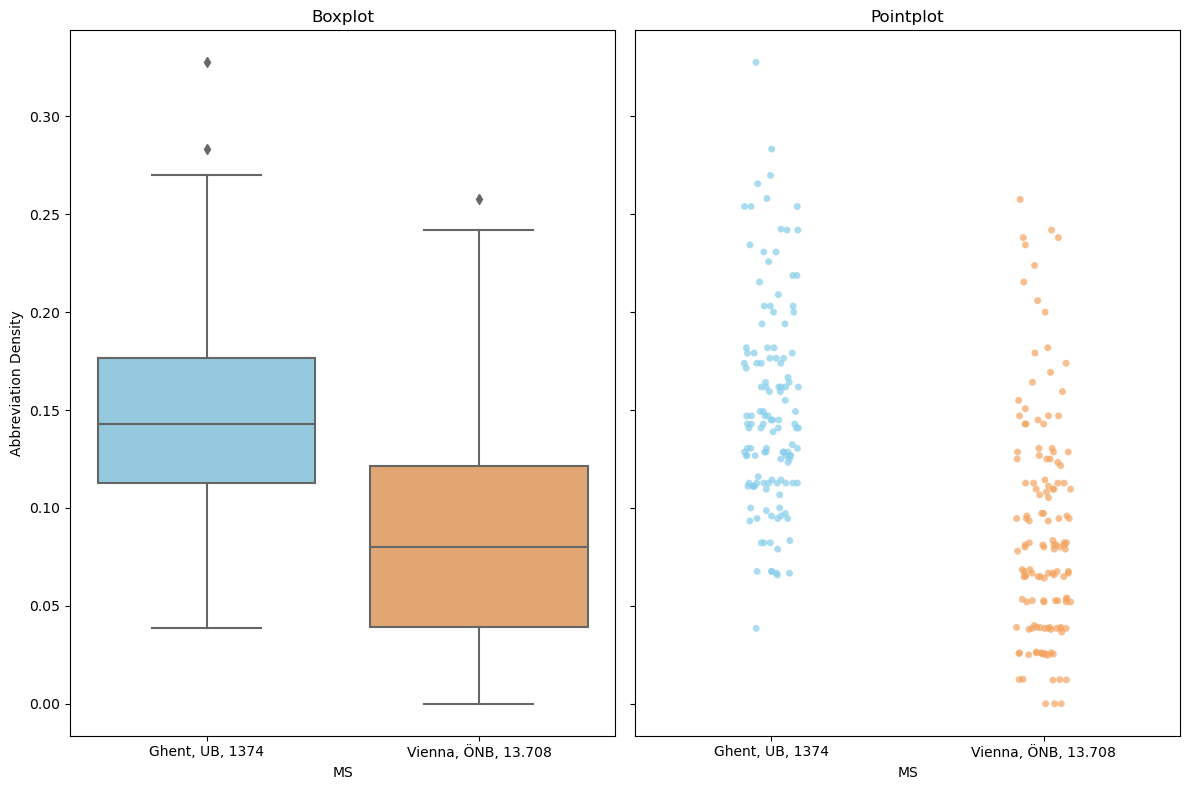

In [75]:
# Creating a boxplot and pointplot for the abbreviation densities per manuscript

densities['segment_index'] = list(range(len(densities)))

# Create figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)

# Boxplot
sns.boxplot(x='MS', y='density', data=densities, ax=axs[0], order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'], palette={'Ghent, UB, 1374': 'skyblue', 'Vienna, ÖNB, 13.708': 'sandybrown'})
axs[0].set_title('Boxplot')
axs[0].set_ylabel('Abbreviation Density')

# Pointplot
sns.stripplot(x='MS', y='density', data=densities, ax=axs[1], order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'], palette={'Ghent, UB, 1374': 'skyblue', 'Vienna, ÖNB, 13.708': 'sandybrown'}, jitter=True, alpha=0.7)
axs[1].set_title('Pointplot')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_52441/3159802370.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],


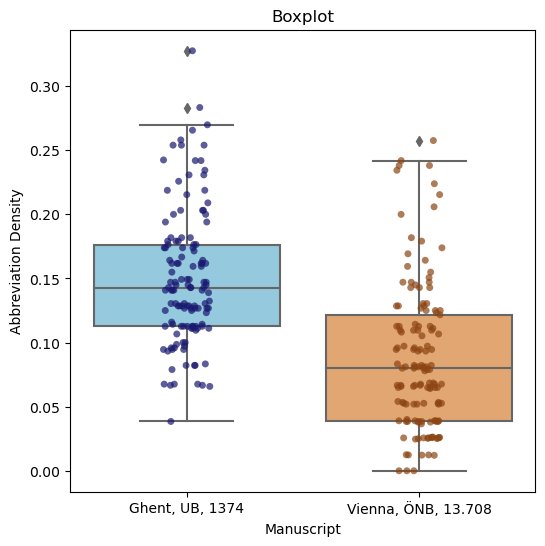

In [76]:
# Assuming 'densities' is your DataFrame
densities['segment_index'] = list(range(len(densities)))

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Boxplot
sns.boxplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],
            palette={'Ghent, UB, 1374': 'skyblue', 'Vienna, ÖNB, 13.708': 'sandybrown'})
ax.set_title('Boxplot')
ax.set_ylabel('Abbreviation Density')
ax.set_xlabel('Manuscript')

# Stripplot (overlaying on the boxplot)
sns.stripplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],
              palette={'Ghent, UB, 1374': 'midnightblue', 'Vienna, ÖNB, 13.708': 'saddlebrown'}, jitter=True, alpha=0.7)

plt.show()



It influences the usage of abbreviations very much! Alpha uses almost twice as many abbreviations in the Ghent version.

In [50]:
# inspect specific segments:

segment_text = densities.iloc[265]['segment_text']
print(segment_text)
cnts = Counter(unicodedata.normalize('NFC', segment_text))
alph = np.sum([cnts[c] for c in set(letters)])
glph = np.sum([cnts[c] for c in set(glyphs)])
print('Abbreviation Density:', glph / alph)

se en̄ spelle Magic leeren alsict vertelle Mijn geloeue al bloet Daer ic bi scumen mach die helle Op
Abbreviation Density: 0.012345679012345678


## Exploratory scatterplots

We explore three different options when creating scatterplots:

- Option 1: use 'segments' as is

- Option 2: remove Saint-Petersburg, BAN, O 256 to see how it influences Vienna, ÖBN, 12.857

- Option 3: only keep in alpha and beta to see if two clusters get formed

#### Option 1: use 'segments' as is

In [51]:
def ngrams(text, ngram_size=1, glyphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFC', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if glyphs_only:
            glyph_present = False
            for char in gram:
                if char in glyphs:
                    glyph_present = True
            if glyph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              glyphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape # amount of segments x number of features

(1218, 100)

In [52]:
# the 100 features

print(vectorizer.get_feature_names_out())

[' ā' ' ē' ' ī' ' ō' ' ꝟ' 'E\ue5dc' 'Wā' 'aē' 'aʼ' 'bē' 'dā' 'dē' 'dī'
 'dʼ' 'dꝫ' 'eʼ' 'e\ue5dc' 'gē' 'gᵒ' 'hā' 'hē' 'hʼ' 'hᵗ' 'hꝫ' 'iē' 'iʼ'
 'i\ue554' 'kē' 'kī' 'kʼ' 'lē' 'lʼ' 'mā' 'mē' 'mī' 'mʼ' 'mꝫ' 'nē' 'nᵗ'
 'oē' 'oʼ' 'oꝫ' 'pē' 'qᵃ' 'rē' 'sē' 'sō' 'tē' 'tʼ' 'uē' 'uʼ' 'vā' 'vʼ'
 'wā' 'wē' 'wʼ' 'ā ' 'ād' 'āt' 'ē ' 'ēd' 'ēn' 'ēs' 'ēt' 'ī ' 'īc' 'īd'
 'īg' 'īn' 'īt' 'ō ' 'ōd' 'ōg' 'ōm' 'ōs' 'ōt' 'ʼ ' 'ʼc' 'ʼd' 'ʼe' 'ʼh'
 'ʼk' 'ʼl' 'ʼm' 'ʼn' 'ʼr' 'ʼs' 'ʼt' 'ʼw' 'ᵃc' 'ᵃm' 'ᵉ ' 'ᵒe' 'ᵒt' 'ᵗ '
 'ⁿ ' 'ꝫ ' 'ꝰ ' '\ue554 ' '\ue5dc ']


In [53]:
import umap.umap_ as umap
pca = PCA(n_components=50)
X = pca.fit_transform(BOW)
print(X.shape) # the dimension is now reduced to 50 
umap = umap.UMAP(n_components=2)
X = umap.fit_transform(X)
print(X.shape) # the dimension is now reduced to two (X and Y-axis)

(1218, 50)
(1218, 2)


In [54]:
output_notebook()

Loading BokehJS ...

In [55]:
# We have to delete NaN from the data column in order for a scatterplot
# to be made
segments_no_nan_dates = segments.dropna(subset=['date']).reset_index(drop=True)

def scatterplot(X, metadata, label_column=None, color_column=None, filename='herne.html'):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in metadata[color_column]])]
        colors = sns.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sns.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['scribe', 'id', 'date', 'translator', 'content']
    d = {c:list(metadata[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = metadata['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"
    output_file(filename)

    p = figure(title='Embeddings',
               tools=TOOLS,
               outer_width=1000,
               outer_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(metadata[label_column], X[:,0], X[:,1]):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="10pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

In [56]:
# Creating a scatterplot with scribes as colours

scatterplot(X, segments_no_nan_dates, label_column=None, color_column='scribe', filename='html/all_segments_scribes.html')

In [57]:
# Creating a scatterplot with ids as colours

scatterplot(X, segments_no_nan_dates, label_column=None, color_column='signature', filename='html/all_segments_codex.html')

Some observations:

- gamma and gamma? are clustered closely together;
- Vienna, ÖBN, 65 is not located in the group of works written by alpha;
- Vienna, ÖBN, 12.857 is located close to the other works written by alpha, but not exactly in the cluster. It is clusters closely to Saint-Petersburg, BAN, O 256. The former was, however, copied from the latter (Hadewijch's works are also clustered together, one was copied from the other;
- Vienna, ÖBN, 13.708 is located inside the cluster.

In [58]:
segments

,text,date,scribe,signature,id,translator,content,abbr_char,abbr_word,class
0,es and net aeroeg ē en wna M Sadoch ghebaer ac...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.118820,0.337461,Rest
1,oemēdʼ erscap Daerōme doet wʼdeghe vᵒcht dʼ p...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.124007,0.345114,Rest
2,r op enen caudelare opt dat se lichte hen alle...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.110703,0.291457,Rest
3,E hē die mꝫ di wilt dinghē in dē vōnesse e ...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.113425,0.310757,Rest
4,e gloriē alse ene vā chs thʼs s porte wāt d...,1337.5,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,evangMath,0.126480,0.332687,Rest
...,...,...,...,...,...,...,...,...,...,...
1213,gende te hare di moꝫ si vornemēde sorge de go...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.193282,0.485915,"Wenen, ÖNB, 13.708"
1214,aʼ teerlīge e spele selē wi vindē bi vele lie...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.183846,0.474438,"Wenen, ÖNB, 13.708"
1215,atine gekeʼt op datse alle mēschē gʼekē e ba...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.202186,0.530955,"Wenen, ÖNB, 13.708"
1216,maect si die vā hoegʼ e van gᵒtʼ matʼiē tᵃc...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.190893,0.510438,"Wenen, ÖNB, 13.708"


#### Option 2: remove Saint-Petersburg, BAN, O 256

In [49]:
print(len(segments))
segments_no_SP = segments[segments['signature'] != 'Sint-Petersburg, BAN, O 256']
print(len(segments_no_SP))

1218
1175


In [50]:
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments_no_SP['text']).toarray()
BOW = preprocessing.scale(BOW)

import umap.umap_ as umap
pca = PCA(n_components=50)
X = pca.fit_transform(BOW)
print(X.shape) # the dimension is now reduced to 50 
umap = umap.UMAP(n_components=2)
X = umap.fit_transform(X)
print(X.shape) # the dimension is now reduced to two (X and Y-axis)

output_notebook()

segments_no_nan_dates = segments_no_SP.dropna(subset=['date']).reset_index(drop=True)

(1175, 50)
(1175, 2)


Loading BokehJS ...

In [51]:
scatterplot(X, segments_no_nan_dates, label_column=None, color_column='scribe', filename='html/no_256_scribes.html')

In [52]:
scatterplot(X, segments_no_nan_dates, label_column=None, color_column='id', filename='html/no_256_codex.html')

Obersvations:
- Vienna, ÖBN, 12.857 is still located close to the cluster of alpha, but is not exactly part of it

#### Option 3: only keep in alpha and beta 

In [53]:
print(len(segments))
segments_a_b = segments[segments['scribe'].isin(['α', 'β'])]
print(len(segments_a_b))

1218
731


In [54]:
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments_a_b['text']).toarray()
BOW = preprocessing.scale(BOW)

import umap.umap_ as umap
pca = PCA(n_components=50)
X = pca.fit_transform(BOW)
print(X.shape) # the dimension is now reduced to 50 
umap = umap.UMAP(n_components=2)
X = umap.fit_transform(X)
print(X.shape) # the dimension is now reduced to two (X and Y-axis)

output_notebook()

segments_no_nan_dates = segments_a_b.dropna(subset=['date']).reset_index(drop=True)

(731, 50)
(731, 2)


Loading BokehJS ...

In [55]:
scatterplot(X, segments_no_nan_dates, label_column=None, color_column='scribe', filename='html/a_b_scribes.html')

In [56]:
scatterplot(X, segments_no_nan_dates, label_column=None, color_column='id', filename='html/a_b_codex.html')

Observations: 
- Beta clusters together perfectly and is isolated from alpha;
- Alpha clusters together overall, but Vienna, ÖNB, 65 is not in the cluster; 
- Vienna, ÖBN, 12.857 is also separated.

## Gamma classification

Gamma and gamma? seemed to be closely related in option 1. Let's zoom in on them.

In [57]:
# voetnoot: ook kmeans clustering?
# ook gamma? en gamma tesamen

In [58]:
### UNCOMMENT IF YOU DONT WANT TO EXCLUDE ANYTHING

# exclude segments with 'scribe2', 'Brussel, KBR, 2877-78-A', 
# and 'Sint-Petersburg, BAN, O 256-G'
excluded_scribes = ['scribe2', 'Brussel, KBR, 2877-78-A', 'Sint-Petersburg, BAN, O 256-G']

# filter the segments dataframe to exclude the specified scribes 
# and signatures
filtered_segments = segments[~segments['scribe'].isin(excluded_scribes)]
segments = filtered_segments

In [59]:
possible_gamma = segments[segments['scribe'] == 'γ?']
print(possible_gamma.shape)
print('-----')
scribes = segments.groupby('scribe').size()
print(scribes)

(11, 10)
-----
scribe
Brussel, KBR, 1805-1808-D                28
Parijs, Bibliothèque Mazarine, 920-A     13
Parijs, Bibliothèque Mazarine, 920-G      3
Parijs, Bibliothèque Mazarine, 920-K      4
Parijs, Bibliothèque Mazarine, 920-L      4
Parijs, Bibliothèque Mazarine, 920-M     15
Sint-Petersburg, BAN, O 256-A             5
Wenen, ÖNB, 12.905-A                     68
Wenen, ÖNB, 13.708-none                   1
scribe1                                  16
scribe3                                  23
α                                       706
β                                        25
γ                                        37
γ?                                       11
ε                                        73
dtype: int64


In [60]:
# We select gamma_segments amount of segments that a scribe produced;
# no more or less
gamma_segments = scribes.loc['γ'] # the amount of segments gamma has written
scribes = scribes[scribes >= gamma_segments] # 25 to include beta (otherwise: gamma_size)
downsampled = segments[segments['scribe'].isin(scribes.index)] # selecting segment with more than 11 segments (gamma's amount)
downsampled = downsampled.groupby('scribe').sample(gamma_segments) # taking a sample of size 11 (gamma's amount)

In [61]:
# onderstaande cel: nu wel standardscaler maar eerst niet?

from sklearn.preprocessing import StandardScaler


In [62]:
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(downsampled['text']).toarray()

scaler = StandardScaler() 
BOW = scaler.fit_transform(BOW)

BOW.shape

(148, 100)

In [63]:
classes = np.zeros(len(downsampled))
classes[downsampled['scribe'] == 'γ'] = 1

In [64]:
# We train a model based on our BOW and the array we created in the previous step
# Segments written by gamma got the label 1, texts not written by gamma got the 
# label 0 
clf = KNeighborsClassifier()
clf.fit(BOW, classes)

# We test the model on the segments written by possible gamma (gamma?). If we get
# 1 back; the model deems it possible that the segments were in fact written by
# gamma
test_X = vectorizer.transform(possible_gamma['text']).toarray()
test_X = scaler.transform(test_X)

print(clf.predict(test_X))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [65]:
# Creating a scatterplot

X = np.vstack([BOW, test_X]) 

import umap.umap_ as umap
pca = PCA(n_components=(50))
X = pca.fit_transform(X)
print(X.shape) # the dimension is now reduced to 50 
umap = umap.UMAP(n_components=2)
X = umap.fit_transform(X)
print(X.shape) # the dimension is now reduced to two (X and Y-axis)

sample_and_possible_gamma = pd.concat([downsampled, possible_gamma])
scatterplot(X, sample_and_possible_gamma, color_column='scribe', filename='html/gamma_classification.html')

(159, 50)
(159, 2)


Observations:
- gamma and gamma? could be the same scribe.
- gamma? wrote together with scribe alpha: could still be located in Herne

## Outlier detection

In [66]:
alpha = segments[segments['scribe'] == 'α'].copy()
BOW = vectorizer.fit_transform(alpha['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(706, 100)

In [67]:
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)
alpha['membership'].value_counts()

membership
-1    356
 1    350
Name: count, dtype: int64

In [68]:
# waarom is dit fifty-fifty?

In [69]:
# We will now have a closer look at production units as a 
# whole instead of just the segments.

# For every production unit , we train a model. The model is
# always trained on all of the production units written by 
# alhpa, except for 1. The model is then tested on the 1 
# work we left out during training to test whether it was 
# written by alpha or not. For every segment we test this
# separately. At the end, you get a percentage of which 
# segments of the production units are anomalies and which are
# not

purity = []

for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])

purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

,unit,codex,-1,+1
0,"Brussel, KBR, 1805-1808-I-α","Brussel, KBR, 1805-1808",0.370370,0.629630
1,"Brussel, KBR, 2849-51-I-α","Brussel, KBR, 2849-51",1.000000,0.000000
2,"Brussel, KBR, 2849-51-II-α","Brussel, KBR, 2849-51",1.000000,0.000000
3,"Brussel, KBR, 2849-51-III-α","Brussel, KBR, 2849-51",0.900000,0.100000
4,"Brussel, KBR, 2849-51-IV-α","Brussel, KBR, 2849-51",1.000000,0.000000
5,"Brussel, KBR, 2849-51-V-α","Brussel, KBR, 2849-51",0.666667,0.333333
6,"Brussel, KBR, 2849-51-VI-α","Brussel, KBR, 2849-51",0.384615,0.615385
7,"Brussel, KBR, 2849-51-VII-α","Brussel, KBR, 2849-51",0.321429,0.678571
8,"Brussel, KBR, 2905-09-II-α","Brussel, KBR, 2905-09",0.477273,0.522727
9,"Brussel, KBR, 3093-95-I-α","Brussel, KBR, 3093-95",0.800000,0.200000


In [70]:
purity.groupby('codex').agg({'-1': 'mean', '+1': 'mean'}).sort_values('-1', ascending=False)

,-1,+1
codex,,
"Wenen, ÖNB, 65",1.000000,0.000000
"Wenen, ÖNB, 12.857",0.921053,0.078947
"Brussel, KBR, 3093-95",0.794737,0.205263
"Brussel, KBR, 2849-51",0.753244,0.246756
"Gent, UB, 1374",0.609074,0.390926
"Wenen, ÖNB, 13.708",0.501362,0.498638
"Brussel, KBR, 2905-09",0.477273,0.522727
"Brussel, KBR, 1805-1808",0.370370,0.629630


Vienna, ÖBN, 65 and Vienna, ÖBN, 12.857 seem to be outliers.

#### (1) Why is Vienna, ÖNB, 65 behaving strangely?

In [71]:
classes = ['Vienna, ÖNB, 65' if sig == 'Wenen, ÖNB, 65' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

nē    0.009844
dꝫ    0.015525
mī    0.015532
dē    0.016055
aʼ    0.019619
dʼ    0.038282
ʼ     0.049360
 ē    0.060143
ʼe    0.061403
ꝫ     0.070112
nᵗ    0.083410
     0.089084
 ī    0.111911
i    0.113037
ī     0.134544
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58708 (\ue554) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


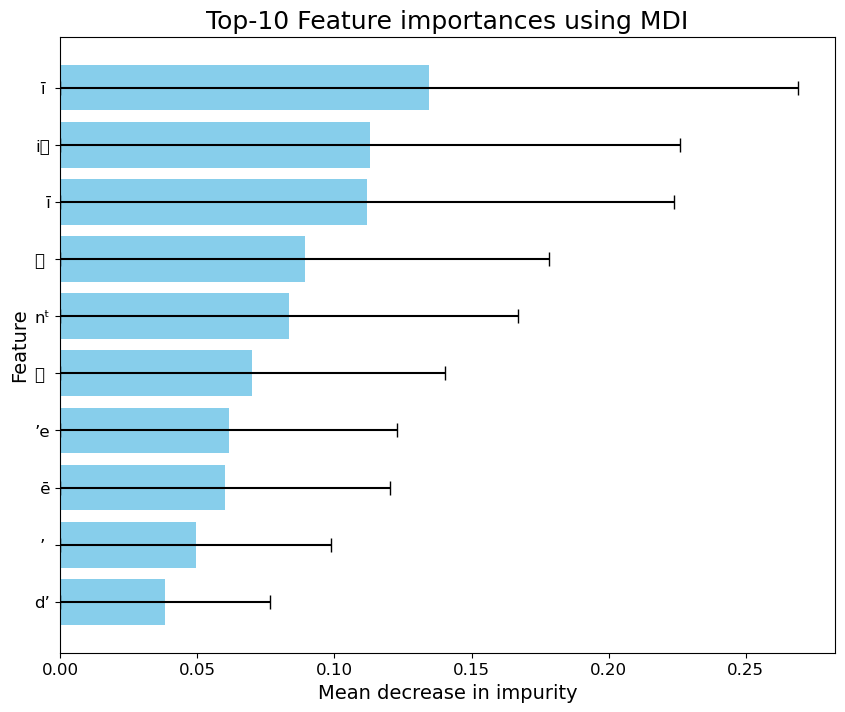

In [72]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='skyblue')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [73]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,dʼ,ʼ,ē,ʼe,ꝫ,nᵗ,,ī,i,ī
rest,-0.371660,0.537941,-0.154921,-0.059459,1.410367,-0.226038,1.495395,-0.951573,1.171292,-1.053186
rest,0.212340,0.806995,1.544144,-0.311080,0.208817,0.311737,1.015462,0.261388,1.079679,0.149949
"Vienna, ÖNB, 65",-1.895731,-2.063752,-1.447922,-1.639402,-1.795558,-1.559173,-1.715725,-1.720782,-1.843900,-1.992762
"Vienna, ÖNB, 65",-1.669019,-1.952539,-1.786602,-1.904538,-1.875546,-1.559173,-1.715725,-2.116428,-1.843900,-2.208604
"Vienna, ÖNB, 65",-1.789676,-2.364679,-1.786602,-1.904538,-1.482244,-1.559173,-1.715725,-1.766653,-1.843900,-1.826968
...,...,...,...,...,...,...,...,...,...,...
rest,1.107412,1.123008,1.836230,0.080757,-0.115831,1.437794,0.066692,-0.317749,-0.036344,-0.361528
rest,-0.061677,0.853390,2.008730,0.359216,0.432402,0.434266,0.240480,-0.216271,0.560700,-0.480904
rest,-0.233650,0.476704,1.882577,1.421421,0.676629,1.103377,-0.575586,1.154718,-0.238040,1.114361
rest,0.248612,1.336300,0.123385,1.221861,0.268408,-0.441983,-0.007170,3.056001,0.033139,3.434974


In [74]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,rest,dʼ,-0.371660,rest
1,rest,dʼ,0.212340,rest
2,"Vienna, ÖNB, 65",dʼ,-1.895731,"Vienna, ÖNB, 65"
3,"Vienna, ÖNB, 65",dʼ,-1.669019,"Vienna, ÖNB, 65"
4,"Vienna, ÖNB, 65",dʼ,-1.789676,"Vienna, ÖNB, 65"
...,...,...,...,...
7055,rest,ī,-0.361528,rest
7056,rest,ī,-0.480904,rest
7057,rest,ī,1.114361,rest
7058,rest,ī,3.434974,rest


/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58708 (\ue554) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


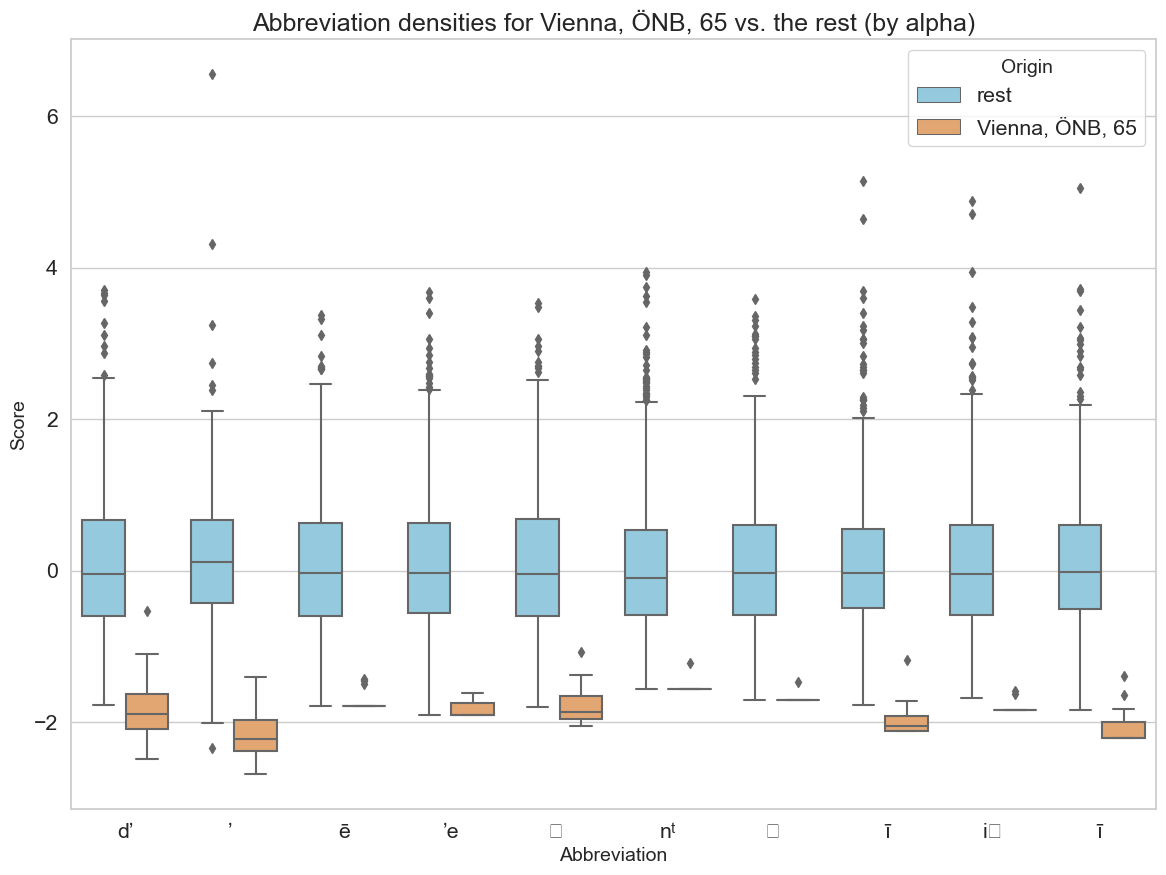

In [75]:
# Set the font style
sns.set(style="whitegrid", font_scale=1.4, font='sans-serif')

# Define a custom color palette with two colors using names
custom_palette = ["skyblue", "sandybrown"]

# Plotting
plt.figure(figsize=(14, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Vienna, ÖNB, 65 vs. the rest (by alpha)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

plt.show()

Abbreviations are almost absent!

#### (2) Why is Vienna, ÖNB, 12.857 behaving strangely?

In [76]:
#params = {'use_idf': True,
#          'max_features': 100,
#          'analyzer': 'word',
#          'min_df': 2}

vectorizer = TfidfVectorizer(**params)

In [77]:
alpha = segments[segments['scribe'] == 'α'].copy()
alpha = alpha[alpha['signature'] != 'Wenen, ÖNB, 65'] #excluce Vienna, ÖNB, 65 since it was not written by α
BOW = vectorizer.fit_transform(alpha['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(672, 100)

In [78]:
classes = ['Wenen, ÖNB, 12.857' if sig == 'Wenen, ÖNB, 12.857' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

E    0.019900
     0.024159
ʼc    0.027318
ēd    0.043598
aʼ    0.068327
ʼ     0.068882
dꝫ    0.091896
hꝫ    0.102630
hē    0.113998
gē    0.190288
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


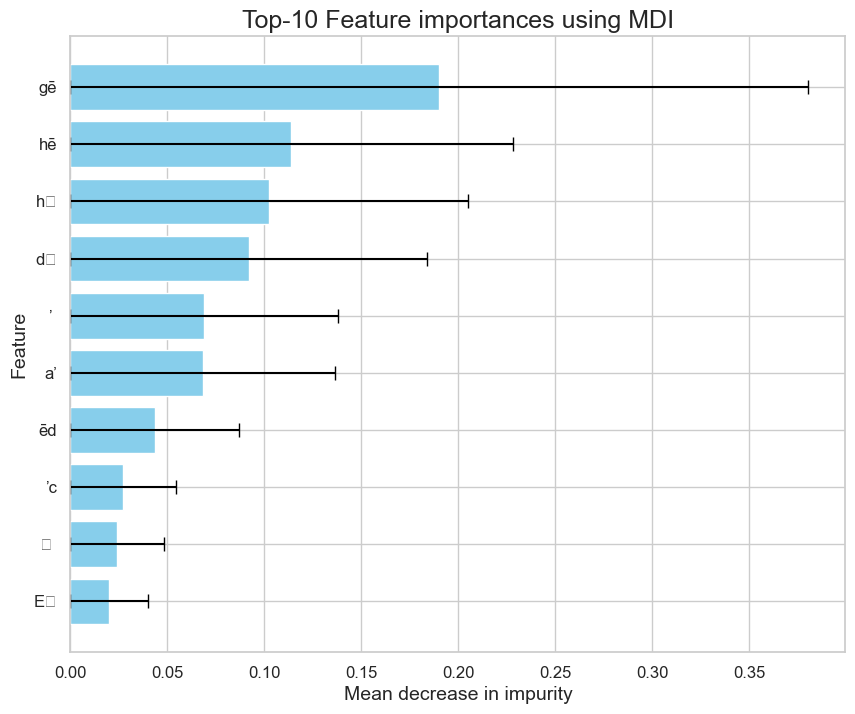

In [79]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='skyblue')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [80]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,E,,ʼc,ēd,aʼ,ʼ,dꝫ,hꝫ,hē,gē
rest,-0.348145,-1.362557,-0.387896,-0.970568,0.823712,0.474130,-0.218547,-0.608204,-0.420056,-0.845532
rest,-0.310401,-1.368573,-0.061432,-0.964698,0.568498,0.833430,-0.502667,-0.608204,-1.045508,2.328078
rest,-0.420486,-0.477993,1.010743,-1.135152,0.668330,4.704666,-1.615865,0.430718,-0.969174,-1.855376
rest,-1.255709,-1.027687,1.259346,-1.135152,-0.987010,7.188787,-1.615865,-0.608204,-1.264027,-0.777258
rest,-1.200720,-1.295686,-0.692622,0.463886,-1.238906,0.226626,-0.153851,-0.247055,-0.649048,-0.547204
...,...,...,...,...,...,...,...,...,...,...
rest,-1.265171,-1.195018,-0.387728,-0.147104,0.391789,1.132990,0.750132,-0.608204,-0.947363,0.670628
rest,-1.124163,-0.196076,-0.387904,-0.147676,0.931882,0.838710,1.393661,-0.608204,-0.525572,1.174074
rest,-1.029290,-0.194137,-0.041151,-0.431427,0.517633,0.418731,1.371450,0.186490,-0.925717,0.843296
rest,-0.999533,-1.311980,-0.692622,-0.818793,0.007107,1.380888,0.760117,1.178069,-0.148721,0.570999


In [81]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,rest,E,-0.348145,rest
1,rest,E,-0.310401,rest
2,rest,E,-0.420486,rest
3,rest,E,-1.255709,rest
4,rest,E,-1.200720,rest
...,...,...,...,...
6715,rest,gē,0.670628,rest
6716,rest,gē,1.174074,rest
6717,rest,gē,0.843296,rest
6718,rest,gē,0.570999,rest


/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


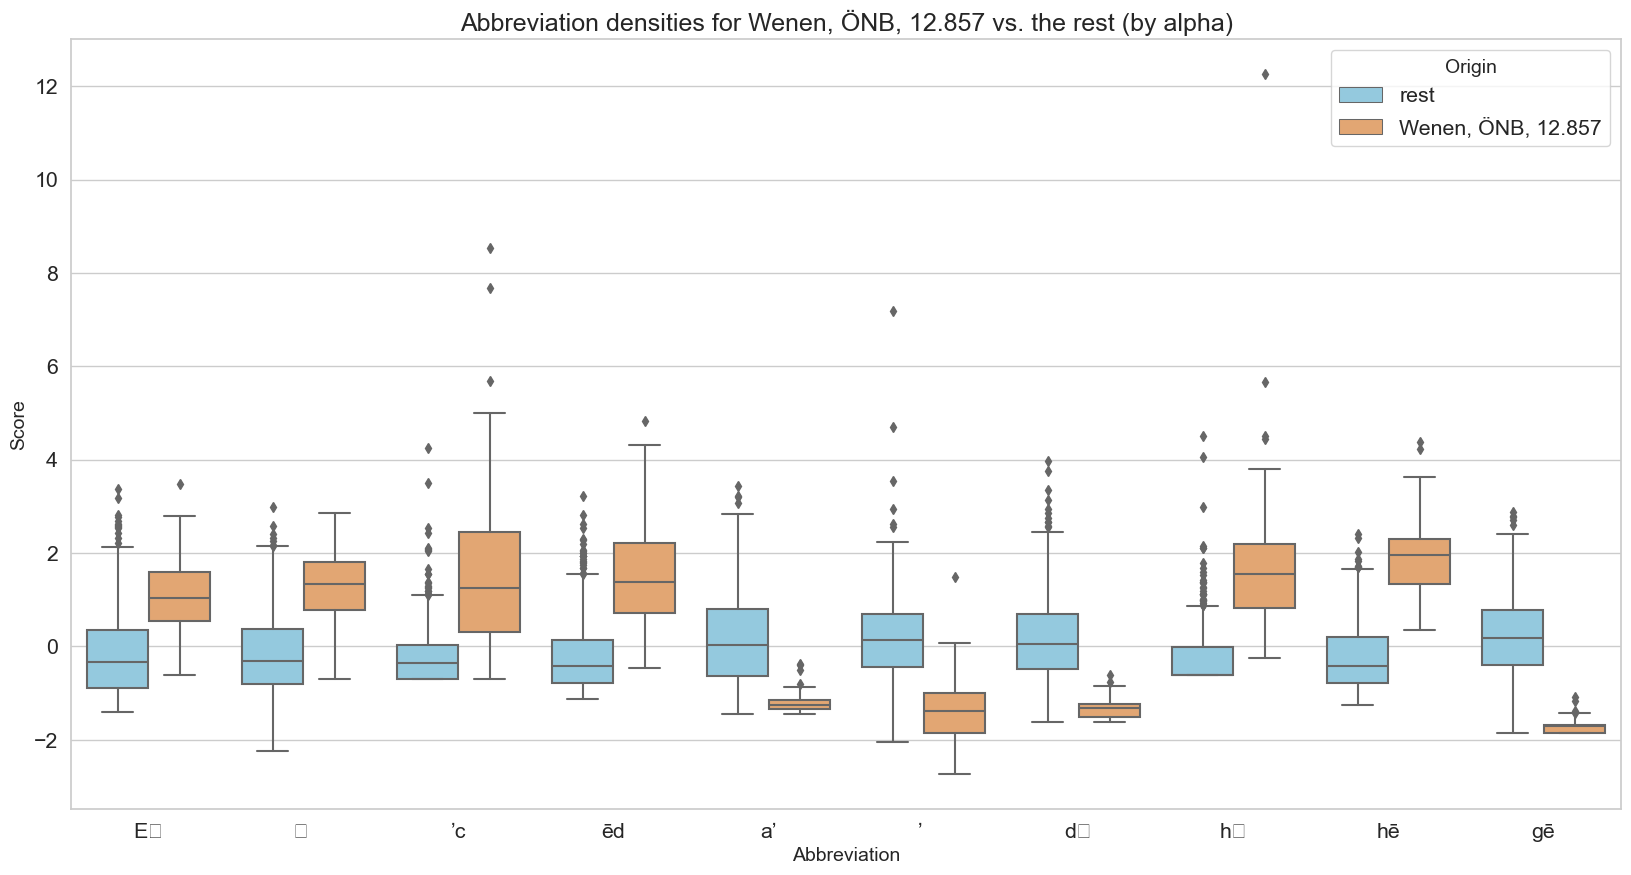

In [82]:
# Set the font style
sns.set(style="whitegrid", font_scale=1.4, font='sans-serif')

# Define a custom color palette with two colors using names
custom_palette = ["skyblue", "sandybrown"]

# Plotting
plt.figure(figsize=(20, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Wenen, ÖNB, 12.857 vs. the rest (by alpha)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

plt.show()

Observations:
- Interestingly: dꝫ is absent in the Vienna manuscript. Let's have a closer look at that.

In [83]:
params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': 'word',
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)

In [84]:
segments

,text,date,scribe,signature,id,translator,content,abbr_char,abbr_word,class
25,he niet sacharia wāt dins bedīghe es ghe horꝫ ...,1337.5,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,0.105263,0.280612,Rest
26,alle dese ghe houꝫ haddē sectēse ī hare hʼte ...,1337.5,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,0.114198,0.339525,Rest
27,die wꝫ ōs herē keer gē si wedʼ ī galylee ī ha...,1337.5,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,0.099109,0.269384,Rest
28,s vol dies heilechs gee sts es wedʼ gekerꝫ vā...,1337.5,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,0.126211,0.333004,Rest
29,se niet sprekē wāt si wiste wel dat hi d was E...,1337.5,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-IV-A",NaN,evangLuc,0.128829,0.325123,Rest
...,...,...,...,...,...,...,...,...,...,...
1213,gende te hare di moꝫ si vornemēde sorge de go...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.193282,0.485915,"Wenen, ÖNB, 13.708"
1214,aʼ teerlīge e spele selē wi vindē bi vele lie...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.183846,0.474438,"Wenen, ÖNB, 13.708"
1215,atine gekeʼt op datse alle mēschē gʼekē e ba...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.202186,0.530955,"Wenen, ÖNB, 13.708"
1216,maect si die vā hoegʼ e van gᵒtʼ matʼiē tᵃc...,1402.0,α,"Wenen, ÖNB, 13.708","Wenen, ÖNB, 13.708-I-α",NaN,supermodo,0.190893,0.510438,"Wenen, ÖNB, 13.708"


In [85]:
alpha = segments[segments['scribe'] == 'α'].copy()
alpha = alpha[alpha['signature'] != 'Wenen, ÖNB, 65'] #excluse Vienna, ÖNB, 65 since it was not written by α
BOW = vectorizer.fit_transform(alpha['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(672, 10000)

In [86]:
classes = ['Wenen, ÖNB, 12.857' if sig == 'Wenen, ÖNB, 12.857' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)[::-1]
std = forest_importances.loc[forest_importances.index][::-1]


# Filter importances and std for presence of "ꝫ"
top_importances = forest_importances[forest_importances.index.str.contains('ꝫ')]
top_std = std.loc[top_importances.index]

# Create DataFrame using top_std instead of top_10_std
top_data = pd.DataFrame({
    'feature': top_importances.index,
    'importance': top_importances.values,
    'importance_lower': top_importances.values - top_std.values,
    'importance_upper': top_importances.values + top_std.values
})

# Display the top data
print(top_data.tail(30))

       feature  importance  importance_lower  importance_upper
93         niꝫ    0.000010               0.0          0.000019
94       maghꝫ    0.000051               0.0          0.000102
95        bedꝫ    0.000099               0.0          0.000198
96        wʼdꝫ    0.000133               0.0          0.000267
97    ghecledꝫ    0.000139               0.0          0.000279
98        bloꝫ    0.000141               0.0          0.000282
99   ghedoeghꝫ    0.000141               0.0          0.000282
100      ghesꝫ    0.000143               0.0          0.000286
101        noꝫ    0.000167               0.0          0.000334
102       vēdꝫ    0.000273               0.0          0.000547
103       nemꝫ    0.000283               0.0          0.000566
104  ghevolghꝫ    0.000286               0.0          0.000571
105        moꝫ    0.000353               0.0          0.000706
106      sendꝫ    0.000396               0.0          0.000792
107        goꝫ    0.000401               0.0          0

In his earlier manuscript, he only uses ꝫ in the traditional way: to abbreviate 'et'. In his later ones, he also does it for 'it' and 'at'